# London Postcode Investment Analysis

## Install Packages

In [1]:
pip install pmdarima

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
Note: you may need to restart the kernel to use updated packages.


In [241]:
pip install descartes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.metrics import smape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
%matplotlib inline
import pickle
import geopandas as gpd
# from fbprophet import Prophet
# from fbprophet.diagnostics import cross_validation
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.plot import plot_cross_validation_metric

# Project Overview

The aim of this project is to forecast the average house price in London postcodes with the aim of providing recommendations for new property buyers who want to grow what is usually the biggest investment we all make in our lives.

If you are one of the below, this product would be useful to you:
- Investors
- Any home buyer
- Emigrating to London 

In [29]:
grouped_multiple = df2.groupby(['district', 'zip', 'month_year']).agg({'price_paid': ['mean', 'min', 'max', percentile(10), percentile(90)]})

In [4]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [3]:
import numpy as np

# Import the Data

As the datasets were so large, it took time to download and the website would regularly time out when trying to run large queries. As a result I downloaded the data in time segments. I will now put them all together.

There is a separate data set which has average prices through time for London Boroughs which I will also load for some EDA. This data came from the same source (Land Registry)

In [4]:
df2000_2002 = pd.read_csv('2000_2002.csv')
df2002_2006 = pd.read_csv('2002_2006.csv')
df2006_2011 = pd.read_csv('2006_2011.csv')
df2011_2016 = pd.read_csv('2011_2016.csv')
df2016_2021 = pd.read_csv('2016_2021.csv')

create a list of the dfs, this may be useful to explore the datasets and ensure I can append them.

In [5]:
dfs = [df2016_2021, df2011_2016, df2006_2011, df2002_2006, df2000_2002]

for df in dfs:
    print(df.shape)

(338887, 16)
(340644, 16)
(350267, 16)
(367691, 16)
(192195, 16)


great, it looks like there are equal number of columns in each dataframe, this should make adding them together relatively simple. 

In [6]:
df2002_2006.head()

unique_id  price_paid   deed_date postcode  \
0  3A04074C-AC1A-46D7-BD91-FBF7501BAD44      173500  28/10/2004   E1 0AE   
1  262FFF4F-0AFC-469E-9C41-BC09FE43F210      171000  16/08/2005   E1 0AE   
2  D3B8DD42-1C71-4551-ACB9-A4C04126AEE7      177000  25/10/2004   E1 0AE   
3  6DA08449-D140-30F2-E053-6B04A8C05F3B      157500  06/02/2003   E1 0AE   
4  261DD75C-2E11-46D7-83AF-C35B100F1B4E      169000  01/07/2004   E1 0AE   

  property_type new_build estate_type saon paon        street locality  \
0             F         N           L  NaN  324  CABLE STREET   LONDON   
1             F         N           L  NaN  326  CABLE STREET   LONDON   
2             F         N           L  NaN  330  CABLE STREET   LONDON   
3             F         N           L  NaN  332  CABLE STREET      NaN   
4             F         N           L  NaN  340  CABLE STREET   LONDON   

     town       district          county transaction_category  \
0  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

In [7]:
df2006_2011.head()

unique_id  price_paid   deed_date postcode  \
0  DF33AD88-E093-4796-B42C-9A10B910D743      115500  16/03/2007   E1 0AD   
1  00E7F6C2-3F26-4123-8475-FA697F239A09      105000  16/03/2007   E1 0AD   
2  8A87041C-93CB-497A-B8E6-56FFEE2552E3      102000  12/03/2007   E1 0AD   
3  35CDF0A7-1550-4555-801A-46DDC0B7171A      150000  11/05/2007   E1 0AD   
4  9021C9C5-FCCD-4203-B43A-2E8BDBA322E0       97500  15/03/2007   E1 0AD   

  property_type new_build estate_type    saon                  paon  \
0             F         Y           L  FLAT 4  BILL FAUST HOUSE, 20   
1             F         Y           L  FLAT 5  BILL FAUST HOUSE, 20   
2             F         Y           L  FLAT 8  BILL FAUST HOUSE, 20   
3             F         Y           L  FLAT 9  BILL FAUST HOUSE, 20   
4             F         N           L  FLAT 1  ADAM MEERE HOUSE, 24   

           street locality    town       district          county  \
0  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
3  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
4  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [8]:
df2011_2016.head()

unique_id  price_paid   deed_date postcode  \
0  CFC960FB-CFB4-4CFB-BDF5-138EF6ECB21B      129500  27/05/2011   E1 0AD   
1  6ADB7B46-76D2-4FB8-BA12-DEEECB58CEB2      270000  08/07/2014   E1 0AD   
2  4123F148-7A6C-4A7D-BBBF-739540D9F688      210000  01/12/2011   E1 0AD   
3  2479F407-6623-4468-B4EE-436C7F00E0C7      250000  17/06/2011   E1 0AD   
4  1570B1D0-C6DD-4B0C-9645-2B3D3A934C8C      249995  29/06/2012   E1 0AE   

  property_type new_build estate_type    saon                  paon  \
0             F         N           L  FLAT 4  BILL FAUST HOUSE, 20   
1             F         N           L  FLAT 8  BILL FAUST HOUSE, 20   
2             F         N           L  FLAT 8  ADAM MEERE HOUSE, 24   
3             F         N           L  FLAT 9  ADAM MEERE HOUSE, 24   
4             F         N           L     NaN                   296   

           street locality    town       district          county  \
0  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
3  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
4    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [9]:
df2016_2021.head()

unique_id  price_paid   deed_date postcode  \
0  8A78B2AF-785C-5CB0-E053-6B04A8C0F504      140000  24/05/2019   E1 0AD   
1  B0A9D11B-5E60-4C1F-E053-6C04A8C0D716      325000  13/08/2020   E1 0AD   
2  8355F008-E752-55C5-E053-6B04A8C0D090      176000  06/12/2018   E1 0AD   
3  4E95D758-19CD-EDA1-E050-A8C0630539E2      450000  31/03/2017   E1 0AE   
4  5376B385-4F7D-34C1-E053-6B04A8C09FF6      440000  23/05/2017   E1 0AE   

  property_type new_build estate_type    saon                  paon  \
0             F         N           L  FLAT 6  BILL FAUST HOUSE, 20   
1             F         N           L  FLAT 8  BILL FAUST HOUSE, 20   
2             F         N           L  FLAT 5  ADAM MEERE HOUSE, 24   
3             F         N           L     NaN                   296   
4             F         N           L     NaN                   314   

           street locality    town       district          county  \
0  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
3    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
4    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    B  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [10]:
df2000_2002.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

all the columns are the same, these dataframes can just be appended. 

In [11]:
new = df2000_2002.append(df2002_2006)
new = new.append(df2006_2011)
new = new.append(df2011_2016)
new = new.append(df2016_2021)
new.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

In [12]:
new.shape

(1589684, 16)

This has been successful, I will now continue with data cleaning and inspection, first though, a description of what these features mean and are they important i.e can I drop them now?

 - unique_id: this is just the id number for the transaction
 - price_paid: In Pound Sterling
 - deed_date: date of completion
 - property_type: detached, semi-detached, terraced or flat maissonette
 - new_build: yes or no
 - estate_type: leasehold or freehold
 - saon: secondary addressable object name, if there is a building that is subdivided into flats for example, there will be an saon.
 - paon: primary addressable object name (typically the house number or name)
 - street: street name
 - locality: in this instance will be London
 - town: if applicable, more granular detail than London could be given
 - district: should represent the Borough.
 - county: greater london in this project
 - transaction_category: standard or additional
 - linked_data: url to transaction information

It looks like many of these columns can be dropped as they will not be particularly useful and the information is often provided in another feature. For example locality and town are similar. Before dropping, I will check for duplicates and null values

In [13]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
3968
property_type
0
new_build
0
estate_type
0
saon
892587
paon
18
street
858
locality
895989
town
0
district
0
county
0
transaction_category
0
linked_data
0


Since I want to ensure I have captured all of the Boroughs, I will do some EDA on this feature now. 

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

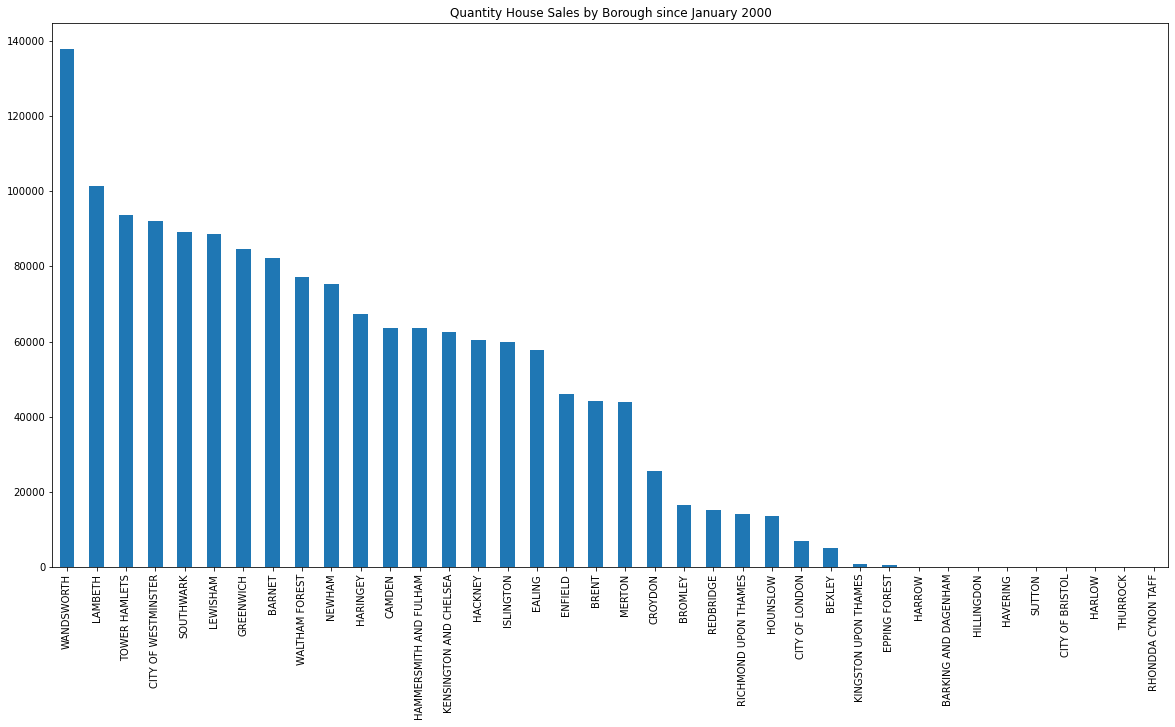

In [14]:
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

It appears that there are some Boroughs that have not been well captured by my initial search. I will run another query for these Boroughs separately and append this data. It is important to capture as much data as possible, but if there is sufficient data for a given Borough I will not re-run the query for it indivually (i.e Wandsworth) 

Another thing, are all of these actually Boroughs of London? No.

There are 32 local authority boroughs in London, plus the City of London which provides the same services as a Borough but to a much smaller area. For the purposes of this project, I will be treating the City of London as a Borough.

In [15]:
boroughs = [
        'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent',
        'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
        'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
        'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
        'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
        'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
        'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster', 'City of London'
    ]

for i in range(len(boroughs)):
    boroughs[i] = boroughs[i].lower()

boroughs


['barking and dagenham',
 'barnet',
 'bexley',
 'brent',
 'bromley',
 'camden',
 'croydon',
 'ealing',
 'enfield',
 'greenwich',
 'hackney',
 'hammersmith and fulham',
 'haringey',
 'harrow',
 'havering',
 'hillingdon',
 'hounslow',
 'islington',
 'kensington and chelsea',
 'kingston upon thames',
 'lambeth',
 'lewisham',
 'merton',
 'newham',
 'redbridge',
 'richmond upon thames',
 'southwark',
 'sutton',
 'tower hamlets',
 'waltham forest',
 'wandsworth',
 'westminster',
 'city of london']

In [16]:
for i in new['district'].unique():
    i = i.lower()
    if i not in boroughs:
        print(i)

epping forest
city of westminster
thurrock
rhondda cynon taff
harlow
city of bristol


In [17]:
# change the name of city of westminster to westminster
new['district'] = new['district'].replace('CITY OF WESTMINSTER', 'WESTMINSTER')

In [18]:
not_boroughs = []
for i in new['district'].unique():
    
    i = i.lower()
    if i not in boroughs:
        not_boroughs.append(i.upper())
        print(i)

epping forest
thurrock
rhondda cynon taff
harlow
city of bristol


In [19]:
not_boroughs

['EPPING FOREST',
 'THURROCK',
 'RHONDDA CYNON TAFF',
 'HARLOW',
 'CITY OF BRISTOL']

I will delete these entries from the dataset.

In [20]:
# remove rows with district values that are not boroughs
new = new[~new['district'].isin(not_boroughs)]



In [21]:
for i in new['district'].unique():
    i = i.lower()
    if i not in boroughs:
        print(i)

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

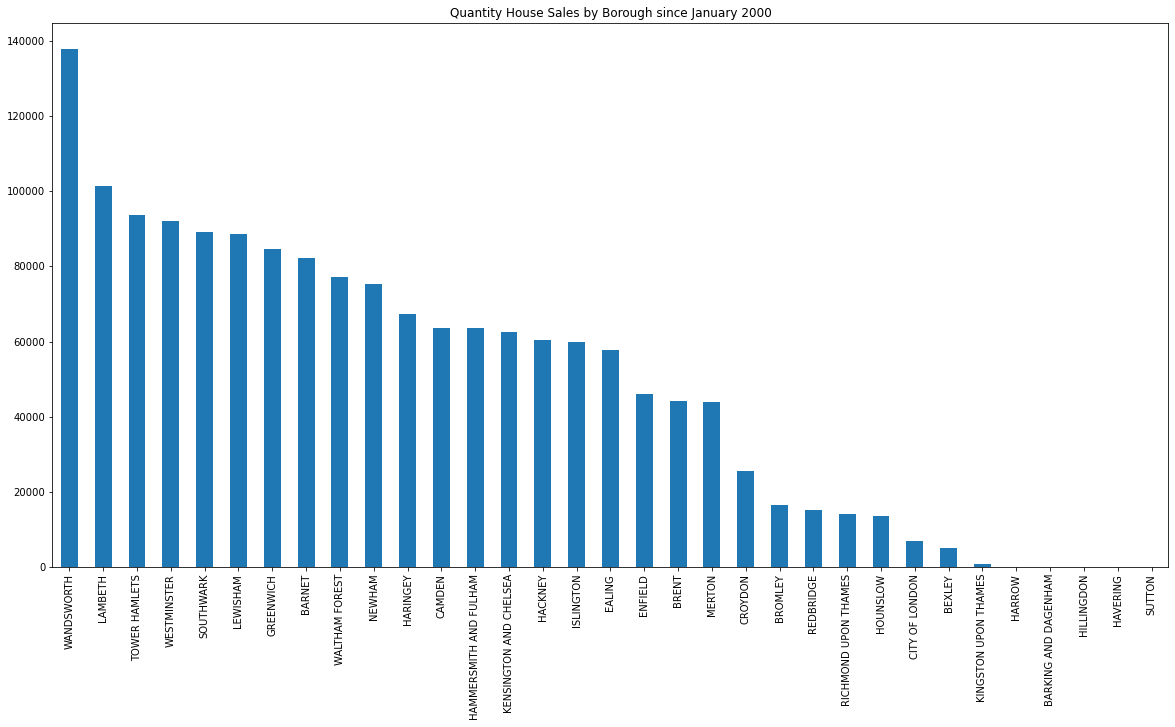

In [22]:
# I will now review the counts again, see where this dataset stands
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

In [23]:
len(new['district'].value_counts())

33

There is now all the boroughs there but some of them are poorly represented, I don't believe this is an accurate reflection of house sales in these boroughs so I will run separate queries for these and append the data to the new dataframe.

In [24]:
barking_df = pd.read_csv('barking.csv')
bexley_df = pd.read_csv('bexley.csv')
bromley_df = pd.read_csv('bromley.csv')
croydon_df = pd.read_csv('croydon.csv')
harrow_df = pd.read_csv('harrow_00_21.csv')
havering_df = pd.read_csv('havering.csv')
kingston_df = pd.read_csv('kingston.csv')
hillingdon_df = pd.read_csv('hillingdon.csv')
redbridge_df = pd.read_csv('redbridge.csv')
richmond_df = pd.read_csv('richmond.csv')
sutton_df = pd.read_csv('sutton.csv')
hounslow_df = pd.read_csv('hounslow.csv')

I will now append all this data to the existing dataframe and then remove duplicates

In [25]:
#create a list of dfs to make appending simple.
dfs_to_append = [barking_df, bexley_df, bromley_df, croydon_df, harrow_df, havering_df, kingston_df, hillingdon_df, redbridge_df, richmond_df, sutton_df, hounslow_df]

for i in dfs_to_append:
    new = new.append(i)

new.shape


(2585998, 16)

In [26]:
new.duplicated(subset='unique_id').sum()

90478

In [27]:
new.drop_duplicates(subset=['unique_id'], keep='last', inplace=True)

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

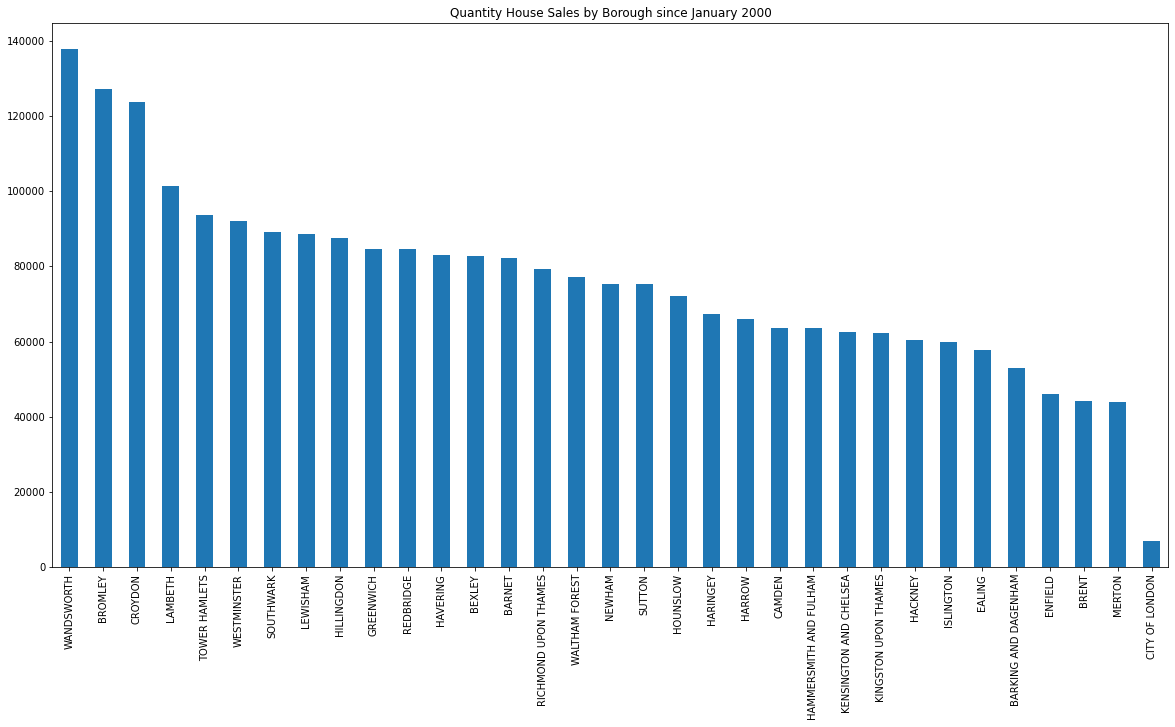

In [28]:
# I will now review the counts again, see where this dataset stands
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

In [29]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
5011
property_type
0
new_build
0
estate_type
0
saon
1624041
paon
39
street
1057
locality
1379534
town
0
district
0
county
0
transaction_category
0
linked_data
0


In [30]:
new.dropna(subset=['postcode'], inplace=True)

In [31]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
0
property_type
0
new_build
0
estate_type
0
saon
1622014
paon
39
street
974
locality
1375453
town
0
district
0
county
0
transaction_category
0
linked_data
0


As I am only interested in the first part of the post code and not going to the next level of detail using the second half, I will create a new column by extracting this information from the post code column.

In [32]:
new[['zip','Last']] = new.postcode.str.split(" ",1, expand=True,)
new.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data zip Last  
0  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AF  
1  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AJ  
2  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AR  
3  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AU  
4  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AZ

In [33]:
new['Month'] = pd.DatetimeIndex(new['deed_date'])
new['month_year'] = pd.to_datetime(new['Month']).dt.to_period('M')

In [34]:
print(f'We have {new.zip.nunique()} different post codes in our dataset for London.')

We have 300 different post codes in our dataset for London.


In [35]:
new[new['month_year']>'2021-05']

unique_id  price_paid   deed_date postcode  \
47     C3C3F9B6-9A45-362B-E053-6B04A8C03ACC     3215000  09/04/2021   E1 0BL   
84     BEF7EBBF-1C2B-7A76-E053-6B04A8C092F7      630000  08/01/2021   E1 0ED   
205    C18F412A-B78D-81A6-E053-6B04A8C0AD18      665000  10/03/2021   E1 0NQ   
230    C3C3F9B5-9F64-362B-E053-6B04A8C03ACC      407500  10/02/2021   E1 0QA   
575    C18F412A-B94A-81A6-E053-6B04A8C0AD18     1050000  11/02/2021   E1 2AN   
...                                     ...         ...         ...      ...   
71146  C3C3F9B6-0FAA-362B-E053-6B04A8C03ACC      415000  12/03/2021   W4 5RH   
71258  C6209F5E-CFA4-295E-E053-6C04A8C0DDCC      761500  11/03/2021   W4 5SB   
71265  C6209F5F-9073-295E-E053-6C04A8C0DDCC     1607000  09/02/2021   W4 5SB   
71554  C6209F5E-D3F3-295E-E053-6C04A8C0DDCC      405000  09/04/2021   W4 5UW   
72021  C6209F5E-D095-295E-E053-6C04A8C0DDCC      682500  11/06/2021   W6 0YE   

      property_type new_build estate_type               saon            paon  \
47                O         N           F                NaN             212   
84                F         N           F                NaN              30   
205               T         N           F                NaN              50   
230               F         N           L                NaN               2   
575               T         N           F                NaN               6   
...             ...       ...         ...                ...             ...   
71146             F         N           L             FLAT 1  MORTLAKE HOUSE   
71258             F         N           L  GROUND FLOOR FLAT              39   
71265             T         N           F                NaN              43   
71554             F         N           L                NaN              24   
72021             F         N           L                NaN              27   

                   street locality    town       district          county  \
47           CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
84           TARBERT WALK      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
205       BELGRAVE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
230       OLD CHURCH ROAD      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
575         WALDEN STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
...                   ...      ...     ...            ...             ...   
71146  CHISWICK HIGH ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71258  THORNEY HEDGE ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71265  THORNEY HEDGE ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71554        ALFRED CLOSE      NaN  LONDON       HOUNSLOW  GREATER LONDON   
72021    RANELAGH GARDENS      NaN  LONDON       HOUNSLOW  GREATER LONDON   

      transaction_category                                        linked_data  \
47                       B  http://landregistry.data.gov.uk/data/ppi/trans...   
84                       A  http://landregistry.data.gov.uk/data/ppi/trans...   
205                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
230                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
575                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
...                    ...                                                ...   
71146                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71258                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71265                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71554                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
72021                    A  http://landregistry.data.gov.uk/data/ppi/trans...   

      zip Last      Month month_year  
47     E1  0BL 2021-09-04    2021-09  
84     E1  0ED 2021-08-01    2021-08  
205    E1  0NQ 2021-10-03    2021-10  
230    E1  0QA 2021-10-02    2021-10  
575    E1  2AN 2021

In [36]:
# Ensure that we erradicate very low prices from data set
new = new[new['price_paid']>10000]

# remove outliers from the data
no_outliers = new[(np.abs(stats.zscore(new['price_paid'])) < 3)].copy()

no_outliers = no_outliers[no_outliers['month_year']<'2021-06'].copy()

count    2.474631e+06
mean     3.989441e+05
std      4.411951e+05
min      1.001100e+04
25%      1.870000e+05
50%      2.800000e+05
75%      4.500000e+05
max      6.520000e+06
Name: price_paid, dtype: float64

In [37]:
new.to_csv('final.csv')
no_outliers.to_csv('no_outliers.csv')

In [38]:
no_outliers['deed_date'] = pd.to_datetime(no_outliers['deed_date'])
s = no_outliers.groupby(['zip',pd.Grouper(key='deed_date', freq='MS')])['price_paid'].mean()

df1 = (s.reset_index(level=0)
        .groupby('zip')['price_paid']
        .apply(lambda x: x.asfreq('MS'))
        .reset_index()
        )

In [39]:
df1.isna().sum()

zip              0
deed_date        0
price_paid    8492
dtype: int64

In [40]:
df1.groupby('zip').head()

zip  deed_date     price_paid
0      BR1 2000-01-01  188510.882353
1      BR1 2000-02-01  166975.060606
2      BR1 2000-03-01  166774.318182
3      BR1 2000-04-01  184542.528090
4      BR1 2000-05-01  164167.565789
...    ...        ...            ...
71012  WD3 2000-01-01  155000.000000
71013  WD3 2000-02-01            NaN
71014  WD3 2000-03-01            NaN
71015  WD3 2000-04-01            NaN
71016  WD3 2000-05-01            NaN

[1473 rows x 3 columns]

In [42]:
print(f'We have {df1.zip.nunique()} different post codes in our dataset for London.')

We have 299 different post codes in our dataset for London.


In [43]:
df1.to_csv('df1.csv')

# EDA

London is an expensive city, everyone knows this, but is it true for all boroughs?

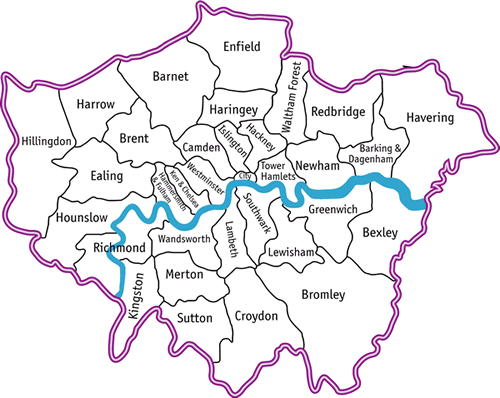

In [376]:
# set the filepath and load in a shapefile
fp = 'London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
# load the average price data per borough
averages = pd.read_csv('boroughs.csv')
averages['average price'] = averages['average price'].str.replace(',', '')
averages['average price'] = averages['average price'].astype(int)
#merge with the geodataframe
merged = map_df.set_index('NAME').join(averages.set_index('borough'))

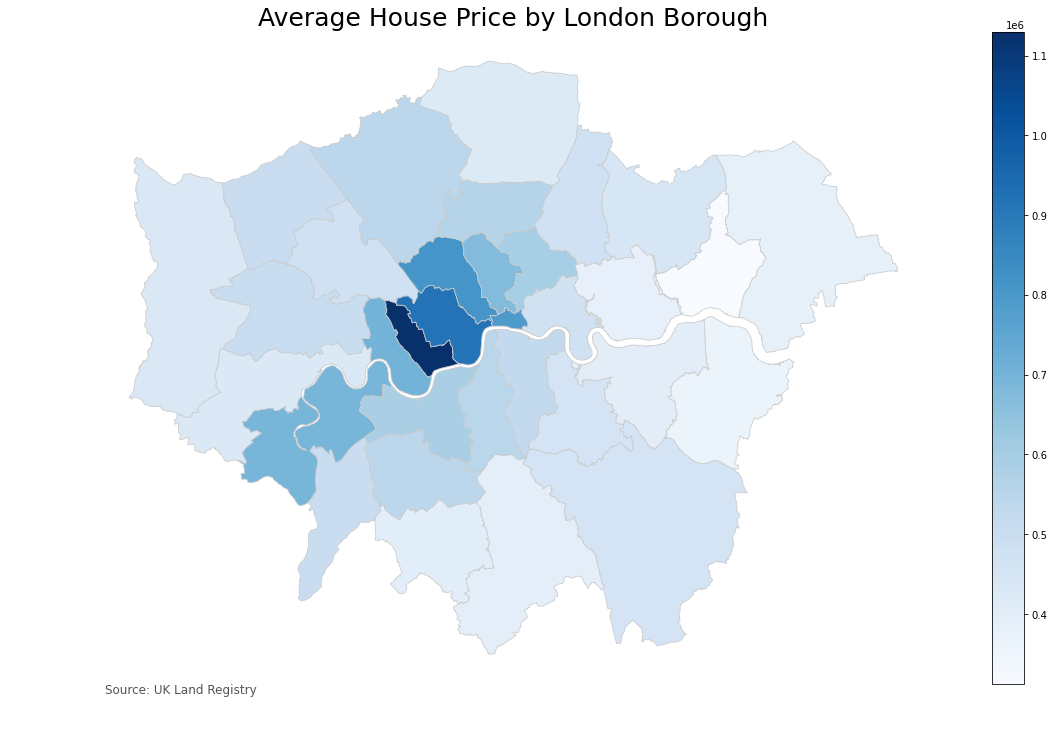

In [377]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'average price'
# set the range for the choropleth
vmin, vmax = merged['average price'].min(), merged['average price'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Average House Price by London Borough', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: UK Land Registry',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8');

London is vast, with 32 Boroughs and The City of London. It can take over 2 hours to navigate from one side to the other, so it is to be expected that there is a lot of diversity in the housing stock. 
This is reflected when you look at the top 5 most expensive Boroughs vs the top 5 most affordable. As can be seen from the map above, Boroughs in Central London and West London are among the most expensive. Kensington and Chelsea has an average house price of over £1million! 

How has this changed over time?

This project is interested in forecasting prices in the future, with that in mind it is useful to look at how prices have varied through time in the past. In london, it can seen some Boroughs have increased more than others.

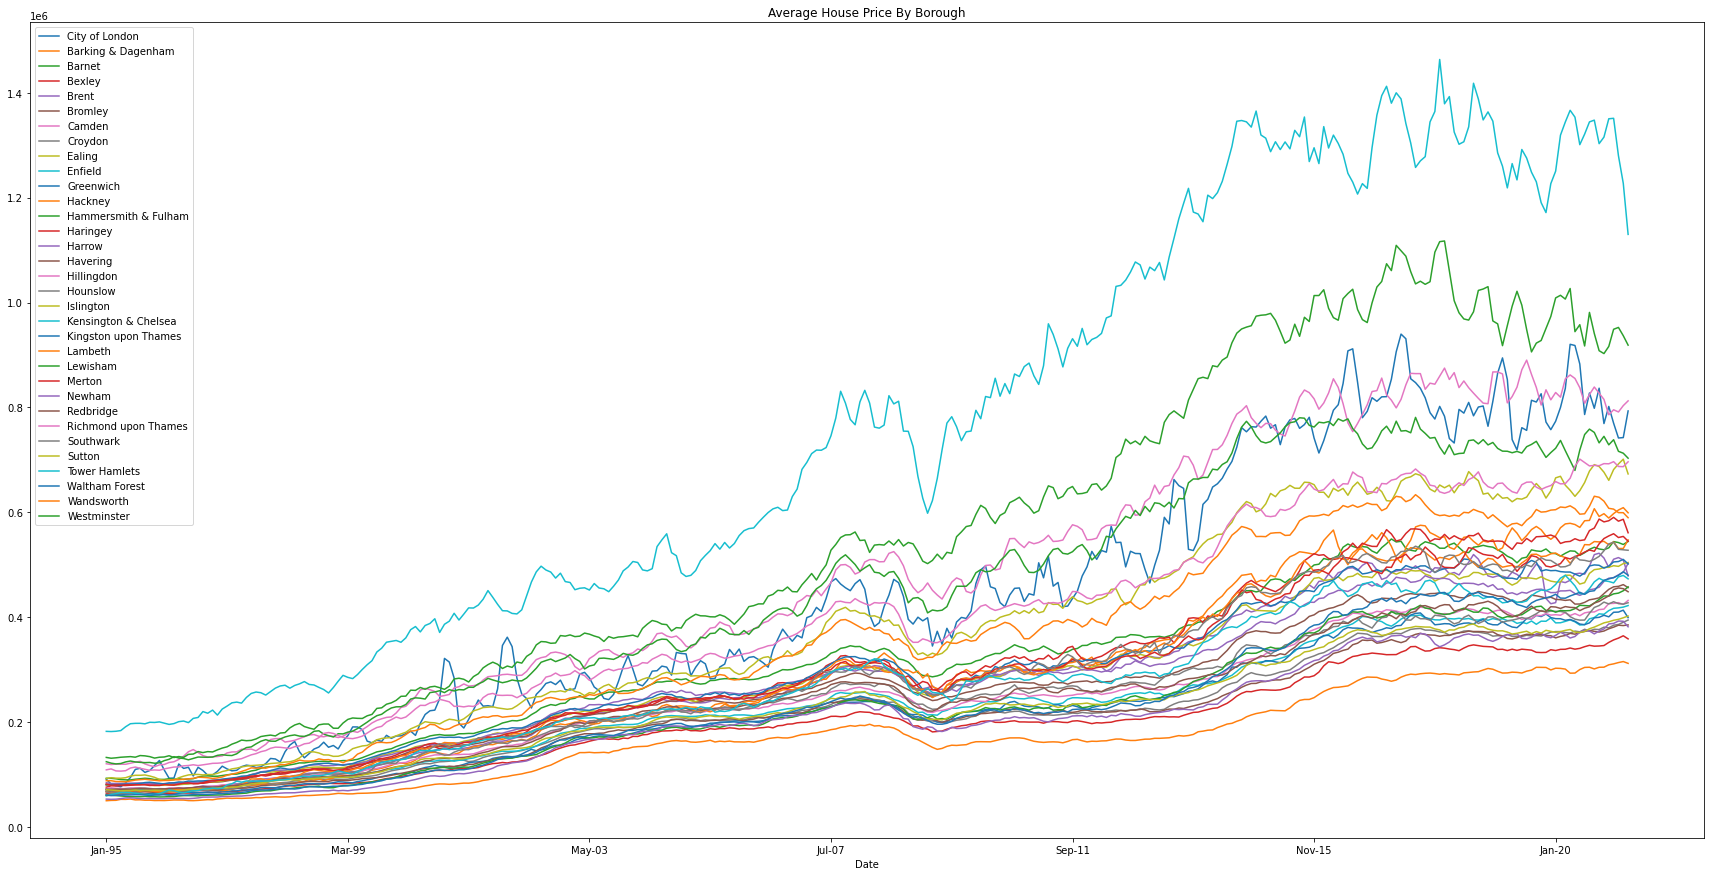

In [399]:
boroughs_time = pd.read_csv('boroughs_averages.csv')
boroughs_time.set_index('Date', inplace=True)
boroughs_time.head()
boroughs_time.plot(figsize=(30,15), title='Average House Price By Borough');

It's very interesting, it may look as if all prices have just gone up, but closer inspection shows that not to be the case.
Very expensive Boroughs, such as Kensington & Chelsea and Westminster are clearly more volatile with higher peaks but deeper troughs. If you have the money to buy here do so with caution. 
Other Boroughs tend to be more stable, gently increasing with time but still fall victim to the Global Recession in 2008. It is clear the impact of any price increase or decrease is felt more in central london, and this dissipates out to other Boroughs. It will be interesting to note the Boroughs here with more volatility and see if this is reflecting in the confidence intervals of any model.

# Modeling

There are various options available to forecasting the prices per post code. 

I will review, Facebook Prophe, ARIMA and SARIMA models. I will do this on one postcode to begin with to review the methodology, then check if this is scalable to use on other post codes.

## Baseline ARIMA

I will attempt a baseline model on one postcode, and compare against other models.

First I will check for stationarity.

In [12]:
df1 = pd.read_csv('df1.csv')

df1.drop('Unnamed: 0', axis=1, inplace=True)
print(df1.head())
br3 = df1[df1['zip']=='BR3'].copy()
br3.drop('zip', axis=1, inplace=True)
br3.columns = ['ds', 'y']
br3.set_index('ds', inplace=True)
br3 = br3.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
br3_train = br3[br3.index < '2019-12-01']
br3_test = br3[(br3.index >= '2019-12-01') & (br3.index < '2021-05-01')]
br3_val = br3[(br3.index >= '2019-01-01') & (br3.index < '2021-05-01')]



   zip   deed_date     price_paid
0  BR1  2000-01-01  188510.882353
1  BR1  2000-02-01  166975.060606
2  BR1  2000-03-01  166774.318182
3  BR1  2000-04-01  184542.528090
4  BR1  2000-05-01  164167.565789


In [13]:
result = adfuller(br3)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.850292
p-value: 0.803901


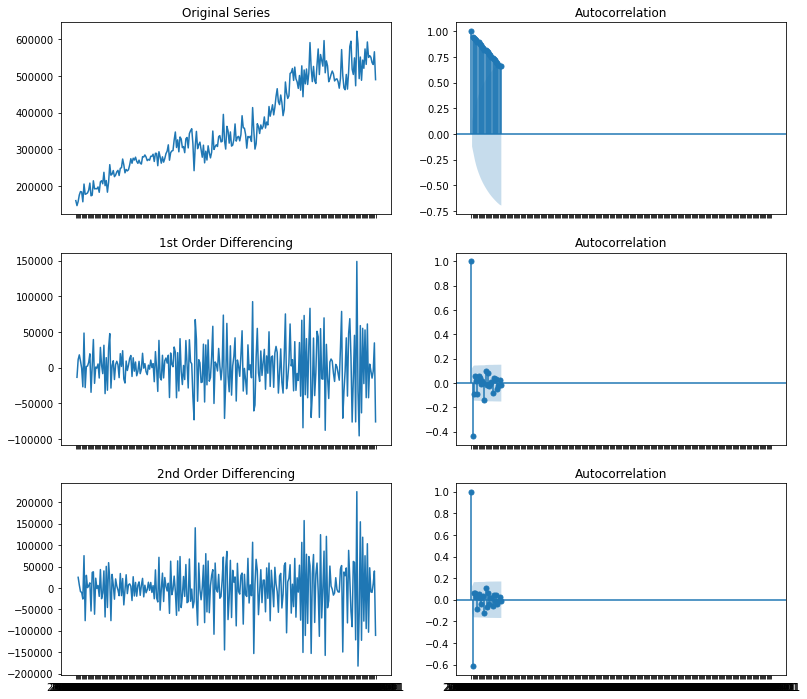

In [18]:
# Original Series

fig, axes = plt.subplots(3, 2, sharex=True)
fig.set_figwidth(13)
fig.set_figheight(12)
axes[0, 0].plot(br3); axes[0, 0].set_title('Original Series')
plot_acf(br3, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(br3.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(br3.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(br3.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(br3.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

From the plots above it looks like stationarity is achieved with first order differencing, I will check this with what pmdarima ndiffs function would recommend

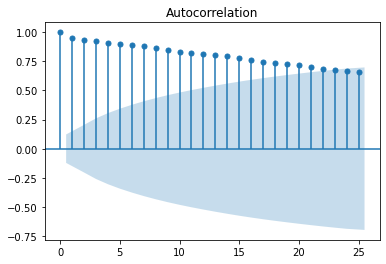

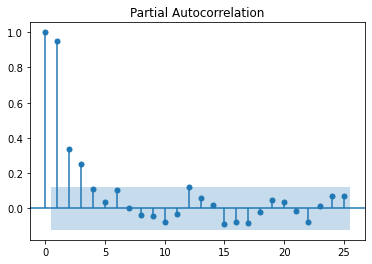

In [20]:
plot_acf(br3)
plot_pacf(br3);

In [23]:
from pmdarima.arima.utils import ndiffs
## Adf Test
print(ndiffs(br3, test='adf'))

# KPSS test
print(ndiffs(br3, test='kpss'))

# PP test:
print(ndiffs(br3, test='pp'))

1
1
0


So it looks like a differencing term of one would be reasonable. 

P value is greater than 0.05 so will require differencing to achieve stationarity

I will now try and find the P term, this can be done by looking at the PACF and checking the number of lags that are significant

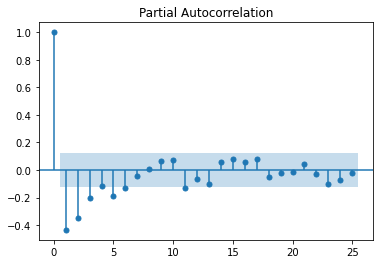

In [27]:
plot_pacf(br3.diff().dropna());

It looks like 4 or 5 could be significant. I will opt with 4.

I will now check the q term, by ploting the Autocorrelation.

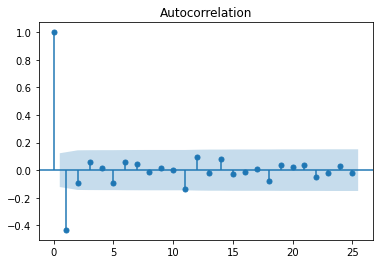

In [29]:
plot_acf(br3.diff().dropna());

it looks like only one lag is significant here, I will use 1 as my q term.

In [39]:
### Base Model

base = ARIMA(br3, order=(4,1,1), freq='MS')
base_fit = base.fit(disp=0)
print(base_fit.summary())

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  256
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2985.236
Method:                       css-mle   S.D. of innovations          28009.313
Date:                Tue, 24 Aug 2021   AIC                           5984.473
Time:                        21:28:33   BIC                           6009.289
Sample:                    02-01-2000   HQIC                          5994.454
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1476.5125    408.125      3.618      0.000     676.602    2276.423
ar.L1.D.y     -0.0167      0.119     -0.141      0.888      -0.250       0.217
ar.L2.D.y     -0.0982      0.098     -0.998      0.3

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


it appears that all of the AR terms are showing as insignificant, I will run a model with these removed. 

In [40]:
base_update = ARIMA(br3, order=(0,1,1), freq='MS')
base_update_fit = base_update.fit(disp=0)
print(base_update_fit.summary())

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  256
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2986.007
Method:                       css-mle   S.D. of innovations          28094.643
Date:                Tue, 24 Aug 2021   AIC                           5978.013
Time:                        21:31:34   BIC                           5988.649
Sample:                    02-01-2000   HQIC                          5982.291
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1482.6089    395.335      3.750      0.000     707.766    2257.452
ma.L1.D.y     -0.7780      0.039    -20.204      0.000      -0.853      -0.703
                                    Roots           

The AIC has barely improved here, but improved nonetheless.

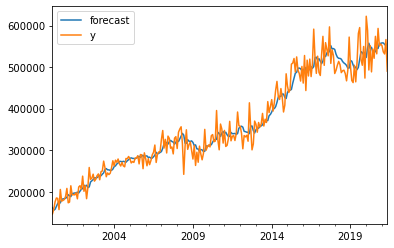

In [41]:
base_update_fit.plot_predict(dynamic=False)
plt.show()

# Auto ARIMA

In [2]:
df1 = pd.read_csv('df1.csv')
df1.drop(columns='Unnamed: 0', inplace=True)
df1.head()

zip   deed_date     price_paid
0  BR1  2000-01-01  188510.882353
1  BR1  2000-02-01  166975.060606
2  BR1  2000-03-01  166774.318182
3  BR1  2000-04-01  184542.528090
4  BR1  2000-05-01  164167.565789

I will now trial Auto-ARIMA on one zip to check results

In [3]:

br3 = df1[df1['zip']=='BR3'].copy()
br3.drop('zip', axis=1, inplace=True)
br3.columns = ['ds', 'y']
br3.set_index('ds', inplace=True)
br3 = br3.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
br3_train = br3[br3.index < '2019-12-01']
br3_test = br3[(br3.index >= '2019-12-01') & (br3.index < '2021-05-01')]
br3_val = br3[(br3.index >= '2019-01-01') & (br3.index < '2021-05-01')]
#cbrt_train3 = np.cbrt(br2)

In [4]:
#We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not which is available in the ‘pmdarima’ package.
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(br3)

#From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

(0.504398791426278, True)

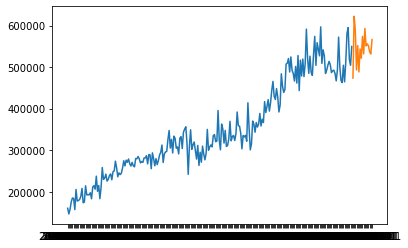

In [7]:
plt.plot(br3_train)
plt.plot(br3_test)

In [17]:
model=auto_arima(br3_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5455.998, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5384.692, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5323.839, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5397.415, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5325.667, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5325.661, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5354.030, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5327.808, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5382.068, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5322.388, Time=0.24 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5396.420, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5324.140, Time=0.28 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5324.133, Time=0.90 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5352.735, Time=0.56 sec
 ARIMA(1,1,1)(1,1,2

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  239
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2655.714
Date:                              Sat, 21 Aug 2021   AIC                           5319.427
Time:                                      16:51:48   BIC                           5333.109
Sample:                                           0   HQIC                          5324.949
                                              - 239                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5227      0.095     -5.493      0.000      -0.709      -0.336
ma.L2         -0.1135      0.094     -1.211      0.226      -0.297       0.070
ma.S.L12      -0.7895      0.082     -9.677      0.000      -0.949      -0.630
sigma2      1.275e+09   2.01e-11   6.33e+19      0.000    1.28e+09    1.28e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                21.92
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+35. Standard errors may be unstable.
"""

In [90]:
len(br3_test)

17

In [10]:
prediction = pd.DataFrame(model.predict(n_periods = len(br3_test)),index=br3_test.index)
prediction.columns = ['predicted_price']
prediction

predicted_price
ds                         
2019-12-01    566647.379121
2020-01-01    531245.915576
2020-02-01    526292.950558
2020-03-01    526553.219829
2020-04-01    559309.794961
2020-05-01    538007.175842
2020-06-01    555189.584044
2020-07-01    561321.264941
2020-08-01    573416.238005
2020-09-01    565226.888164
2020-10-01    541562.887742
2020-11-01    555617.825736
2020-12-01    584003.669078
2021-01-01    551237.911279
2021-02-01    546284.946261
2021-03-01    546545.215531
2021-04-01    579301.790664

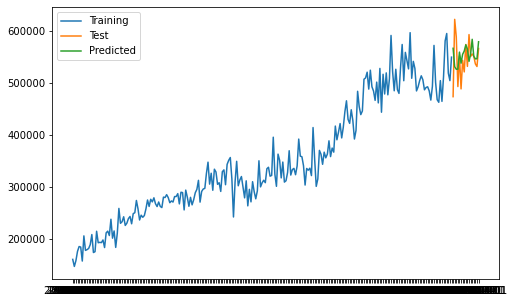

In [11]:
plt.figure(figsize=(8,5))
plt.plot(br3_train,label="Training")
plt.plot(br3_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
#plt.savefig('SecondPrection.jpg')
plt.show()

In [12]:
br3_test['predicted_price'] = prediction
smape(br3_test['y'], br3_test['predicted_price'])

<ipython-input-12-5753df95daa2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br3_test['predicted_price'] = prediction


5.876876743392727

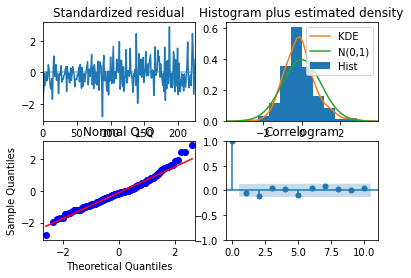

In [20]:
model.plot_diagnostics();

In [23]:
def stationarity_check(ts):
            
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=12, center=False).mean()
    roll_std = ts.rolling(window=12, center=False).std()

    # Perform the Dickey Fuller test
    dftest = adfuller(ts) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results

    print('\nResults of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [25]:
br3_ave = br3.rolling(window=12, center=False).mean()

In [105]:
br3_ave.tail(12)

y
ds                       
2020-06-01  542549.639664
2020-07-01  537570.968699
2020-08-01  535807.412274
2020-09-01  536894.081281
2020-10-01  544281.454727
2020-11-01  544382.203494
2020-12-01  551230.047364
2021-01-01  545307.092701
2021-02-01  540966.584132
2021-03-01  544182.899647
2021-04-01  545379.267877
2021-05-01  545523.943803

In [28]:
br3ave_train = br3_ave[(br3_ave.index >= '2000-12-01') & (br3_ave.index < '2019-12-01')]
br3ave_test = br3_ave[(br3_ave.index >= '2019-12-01') & (br3_ave.index < '2021-05-01')]

#cbrt_train3 = np.cbrt(br2)

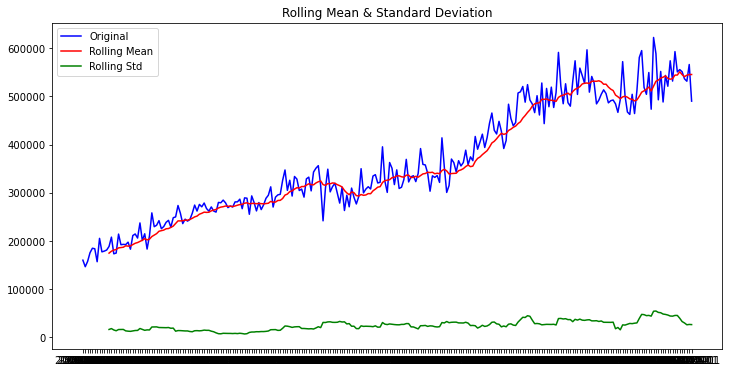


Results of Dickey-Fuller Test: 

Test Statistic                  -0.850292
p-value                          0.803901
#Lags Used                       6.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


In [24]:
stationarity_check(br3)

In [29]:
model=auto_arima(br3ave_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4284.312, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4268.295, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4281.746, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4262.372, Time=0.33 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=4259.982, Time=0.82 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=4259.876, Time=1.53 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=4260.318, Time=3.26 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=4254.726, Time=6.56 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=4256.502, Time=9.83 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=4256.043, Time=5.43 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=3.24 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=9.02 sec
 ARIMA(0,1,0)(4,1,1)[12]             : 

In [36]:
prediction, conf = model.predict(n_periods = len(br3ave_test), return_conf_int=True)

prediction
conf

array([[514726.70401128, 533803.16903146],
       [511778.88469995, 539610.18742444],
       [507471.85096286, 541942.97133674],
       [502713.02330336, 542739.54667535],
       [500182.19052598, 545082.06472544],
       [496019.18720035, 545312.95518136],
       [495895.91920762, 549222.76484656],
       [499691.11280507, 556766.75885933],
       [504332.61947671, 564925.5751478 ],
       [505026.73647734, 568943.73845837],
       [505987.78833171, 573064.30714651],
       [508067.40780066, 578161.09263815],
       [509192.88224981, 586982.84807588],
       [506951.86039638, 592077.87930118],
       [503265.03898858, 595162.79526218],
       [499039.95454353, 597244.74305771],
       [496414.89153196, 600545.46987476]])

In [62]:
preds = pd.DataFrame(prediction, columns = ['preds'], index=br3ave_test.index)
conf_int = pd.DataFrame(conf, columns = ['low', 'high'], index=br3ave_test.index)

Text(0.5, 0, 'Year')

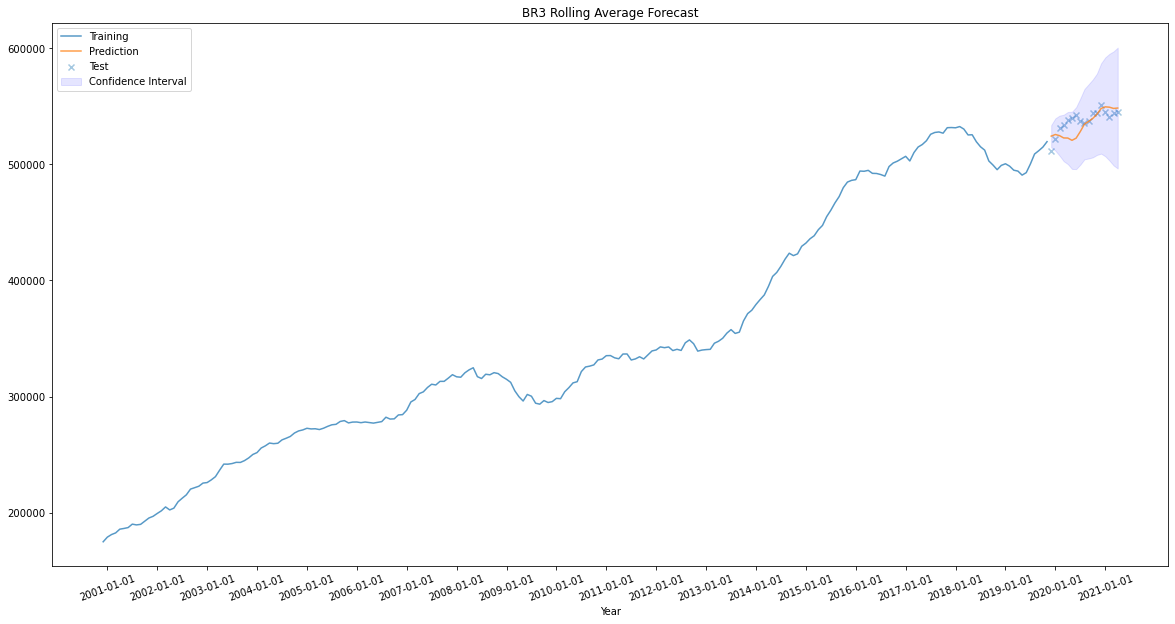

In [101]:
# Plot the points and the forecasts
import matplotlib.dates as mdates



plt.figure(figsize=(20,10))
plt.plot(br3ave_train, alpha=0.75, label="Training")
plt.plot(preds, alpha=0.75, label='Prediction')  # Forecasts
plt.scatter(br3ave_test.index, br3ave_test,
            alpha=0.4, marker='x', label='Test')  # Test data
plt.fill_between(br3ave_test.index, conf_int['high'], conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
plt.legend(loc='upper left')
plt.xticks(br3_ave.index[12::12], rotation=20 )
plt.title("BR3 Rolling Average Forecast")
plt.xlabel("Year")

In [102]:
model.update(br3ave_test)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(4, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [103]:
new_prediction, new_conf = model.predict(n_periods = 60, return_conf_int=True)

In [139]:
rng = pd.date_range('2021-06-01', periods=60, freq='MS')

In [136]:
br3_ave.index = pd.to_datetime(br3_ave.index, format = '%Y/%m/%d')

In [137]:
br3_ave.index[12::12]

DatetimeIndex(['2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01',
               '2021-01-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [110]:
br3_ave.index.append(rng)

Index([       '2000-01-01',        '2000-02-01',        '2000-03-01',
              '2000-04-01',        '2000-05-01',        '2000-06-01',
              '2000-07-01',        '2000-08-01',        '2000-09-01',
              '2000-10-01',
       ...
       2025-08-01 00:00:00, 2025-09-01 00:00:00, 2025-10-01 00:00:00,
       2025-11-01 00:00:00, 2025-12-01 00:00:00, 2026-01-01 00:00:00,
       2026-02-01 00:00:00, 2026-03-01 00:00:00, 2026-04-01 00:00:00,
       2026-05-01 00:00:00],
      dtype='object', length=317)

In [134]:
new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng.dt.strftime('%Y-%m-%d'))
new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng.dt.strftime('%Y-%m-%d'))

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

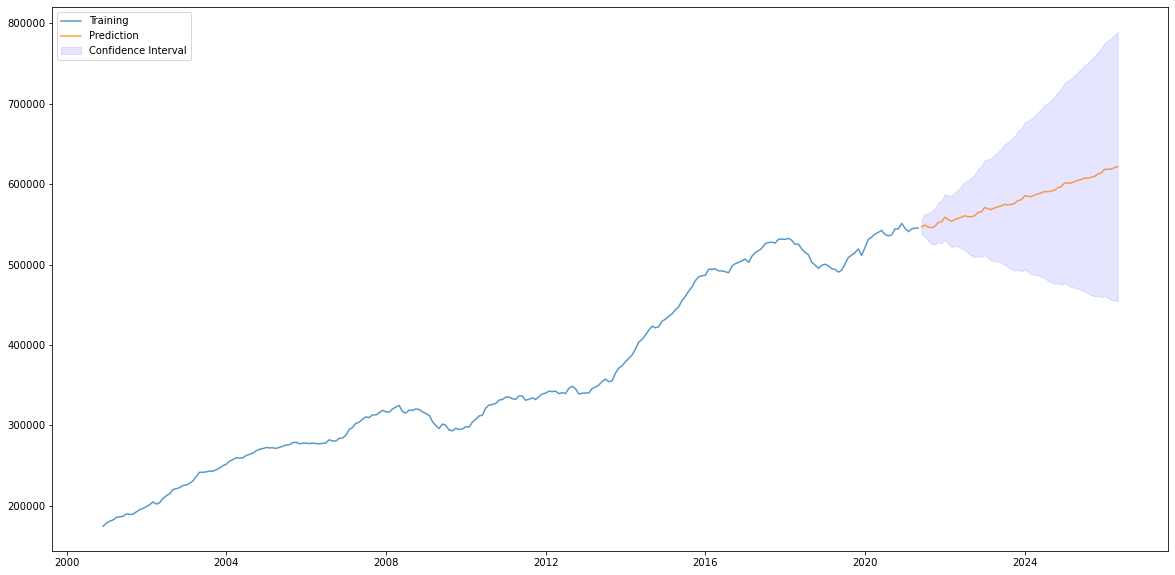

In [147]:
plt.figure(figsize=(20,10))
plt.plot(br3_ave, alpha=0.75, label="Training")
plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
#plt.scatter(br3ave_test.index, br3ave_test,
            #alpha=0.4, marker='x', label='Test')  # Test data
plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
plt.legend(loc='upper left')
#plt.xticks(br3_ave.index[12::12], rotation=20 )
# plt.title("BR3 Rolling Average Forecast")
# plt.xlabel("Year")

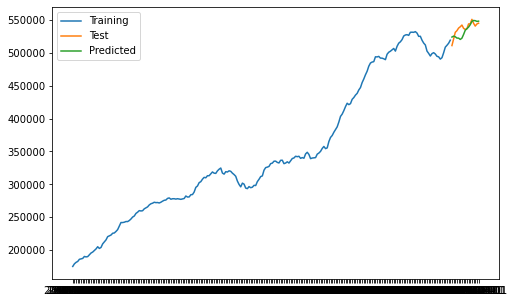

In [31]:
plt.figure(figsize=(8,5))
plt.plot(br3ave_train,label="Training")
plt.plot(br3ave_test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
#plt.savefig('SecondPrection.jpg')
plt.show()

In [32]:
smape(br3ave_test['y'], prediction['predicted_price'])

1.427168629768669

This approach is reasonably fast and compares well against other more labour intensive methods. For a project that requires the evaluation of so many zip codes, it seems sensible to use pmdarima.

In [163]:
list_of_zips = list(df1['zip'].unique())
summary_test = pd.DataFrame({'Zip': [], 'SMAPE':[]})
summary_forecast = pd.DataFrame({'Zip': [], '5_year_Low': [], '5_year_mid': [], '5_year_high': [], 'low_ror': [], 'mid_ror': [], 'high_ror': []})

trials = ['BR1', 'BR2']
summary_auto

Zip     SMAPE
0  BR1  8.031762
1  BR2  3.630422

In [205]:
not_modelled = []
for value in list_of_zips:
    if value not in summary_forecast.Zip.unique():
        not_modelled.append(value)
        

In [209]:
for x in not_modelled:
    not_df = df1[df1['zip']==x].copy()
    not_df.drop('zip', axis=1, inplace=True)
    not_df.columns = ['ds', 'y']
    not_df.set_index('ds', inplace=True)
    not_df.index = pd.to_datetime(not_df.index, format = '%Y/%m/%d')
    not_df = not_df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
    print(x)
    print(len(not_df))
    print(not_df.tail())
    print('\n')

BR8
247
                        y
ds                       
2020-06-01  250000.000000
2020-07-01  486065.573770
2020-08-01  730000.000000
2020-09-01  788442.622951
2020-10-01  845000.000000


CM13
217
                       y
ds                      
2017-11-01  2.333351e+06
2017-12-01  2.383763e+06
2018-01-01  2.435856e+06
2018-02-01  2.487948e+06
2018-03-01  2.535000e+06


CM14
21
                        y
ds                       
2005-04-01  741986.863711
2005-05-01  743957.307061
2005-06-01  745993.431856
2005-07-01  747963.875205
2005-08-01  750000.000000


CR3
256
                        y
ds                       
2020-12-01  496666.666667
2021-01-01  486000.000000
2021-02-01  455000.000000
2021-03-01  460000.000000
2021-04-01  470000.000000


CR6
252
                        y
ds                       
2020-08-01  460359.477124
2020-09-01  410718.954248
2020-10-01  362679.738562
2020-11-01  313039.215686
2020-12-01  265000.000000


CR9
165
                       y
ds           

In [199]:
CR3_df = df1[df1['zip']=='CR3'].copy()
CR3_df.drop('zip', axis=1, inplace=True)

CR3_df.columns = ['ds', 'y']
CR3_df.set_index('ds', inplace=True)
CR3_df.index = pd.to_datetime(CR3_df.index, format = '%Y/%m/%d')
CR3_df = CR3_df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
print(len(CR3_df))
CR3_df

256


y
ds                       
2000-01-01  167225.000000
2000-02-01  177475.000000
2000-03-01  148450.000000
2000-04-01  172250.000000
2000-05-01  151500.000000
...                   ...
2020-12-01  496666.666667
2021-01-01  486000.000000
2021-02-01  455000.000000
2021-03-01  460000.000000
2021-04-01  470000.000000

[256 rows x 1 columns]

In [181]:
CR3_df.index = pd.to_datetime(CR3_df.index, format = '%Y/%m/%d')
CR3_df = CR3_df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)

In [183]:
for x,i in enumerate(list_of_zips):
    df = df1[df1['zip']==i].copy()
    if len(df) < 257:
        continue
    #print(df.head())
    df.drop('zip', axis=1, inplace=True)
    #print(df.head())
    df.columns = ['ds', 'y']
    df.set_index('ds', inplace=True)
    df.index = pd.to_datetime(df.index, format = '%Y/%m/%d')
    df = df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
    print(i)
    print(df.head())
    df_ave = df.rolling(window=12, center=False).mean()
    train = df_ave[(df_ave.index >= '2000-12-01') & (df_ave.index < '2019-12-01')]
    test = df_ave[(df_ave.index >= '2019-12-01') & (df_ave.index < '2021-05-01')]
    model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
    prediction, conf = model.predict(n_periods = len(test), return_conf_int=True)
    preds = pd.DataFrame(prediction, columns = ['preds'], index=test.index)
    conf_int = pd.DataFrame(conf, columns = ['low', 'high'], index=test.index)
    plt.figure(figsize=(20,10))
    plt.plot(train, alpha=0.75, label="Training")
    plt.plot(preds, alpha=0.75, label='Prediction')  # Forecasts
    plt.scatter(test.index, test,
            alpha=0.4, marker='x', label='Test')  # Test data
    plt.fill_between(test.index, conf_int['high'], conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
    plt.legend(loc='upper left')
    plt.xticks(df_ave.index[12::12], rotation=20 )
    plt.title("{} Prediction vs Test".format(i), fontsize=20)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Price (£)", fontsize=20)
    plt.savefig('{}_test.png'.format(i), bbox_inches = 'tight')
    plt.close()
    smape_auto = smape(test['y'], preds)
    summary_auto.loc[x] = [i, smape_auto]
    print('Symmetric Mean Absolute Percentage Error: ', smape_auto)
    model.update(test)
    new_prediction, new_conf = model.predict(n_periods = 60, return_conf_int=True)
    rng = pd.date_range('2021-06-01', periods=60, freq='MS')
    df_ave.index = pd.to_datetime(df_ave.index, format = '%Y/%m/%d')
    new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng)
    new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng)
    plt.figure(figsize=(20,10))
    plt.plot(df_ave, alpha=0.75, label="Training")
    plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
    #plt.scatter(br3ave_test.index, br3ave_test,
            #alpha=0.4, marker='x', label='Test')  # Test data
    plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
    plt.legend(loc='upper left')
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Price (£)", fontsize=20)
    plt.title("{} Forecast".format(i), fontsize=20)
    plt.savefig('{}_forecast.png'.format(i), bbox_inches = 'tight')
    plt.close()
    lowror = round((((new_conf_int['low'].iloc[-1] - new_conf_int['low'].iloc[0])/new_conf_int['low'].iloc[0])*100), 2)
    midror = round((((new_preds['preds'].iloc[-1] - new_preds['preds'].iloc[0])/new_preds['preds'].iloc[0])*100),2)
    highror = round((((new_conf_int['high'].iloc[-1] - new_conf_int['high'].iloc[0])/new_conf_int['high'].iloc[0])*100), 2)
    summary_forecast.loc[x] = [i, round(new_conf_int['low'].iloc[-1],0), round(new_preds['preds'].iloc[-1],0), round(new_conf_int['high'].iloc[-1],0), lowror, midror, highror]
    with open('{}.pkl'.format(i), 'wb') as pkl:
        pickle.dump(model, pkl)


BR1
                        y
ds                       
2000-01-01  188510.882353
2000-02-01  166975.060606
2000-03-01  166774.318182
2000-04-01  184542.528090
2000-05-01  164167.565789
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4457.528, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4437.736, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4426.764, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4459.100, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4414.237, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4437.993, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4416.037, Time=0.71 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4416.063, Time=1.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4416.359, Time=0.91 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4428.415, Time=0.51 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(1,1,1)[12]             : 

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,1)(5,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,1,1)(5,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(5,1,1)[12]             : AIC=inf, Time=18.09 sec
 ARIMA(0,1,0)(5,1,1)[12] intercept   : AIC=inf, Time=11.51 sec

Best model:  ARIMA(0,1,0)(5,1,1)[12]          
Total fit time: 95.184 seconds
Symmetric Mean Absolute Percentage Error:  2.876188133729136
EC2Y
                        y
ds                       
2000-01-01  293730.769231
2000-02-01  218555.555556
2000-03-01  249375.000000
2000-04-01  276928.571429
2000-05-01  202277.272727
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4992.234, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4922.688, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4900.827, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4990.967, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4902.288, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4902.294, Time=0.98 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AI

In [187]:
summary_forecast.Zip.unique()

array(['BR1', 'BR2', 'BR3', 'BR4', 'BR5', 'BR6', 'BR7', 'CR0', 'CR2',
       'CR4', 'CR5', 'CR7', 'CR8', 'DA1', 'DA14', 'DA15', 'DA16', 'DA17',
       'DA18', 'DA5', 'DA6', 'DA7', 'DA8', 'E1', 'E10', 'E11', 'E12',
       'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E1W', 'E2', 'E3', 'E4',
       'E5', 'E6', 'E7', 'E8', 'E9', 'EC1M', 'EC1R', 'EC1V', 'EC1Y',
       'EC2Y', 'EC3N', 'EC4A', 'HA1', 'HA2', 'HA3', 'HA4', 'HA5', 'HA6',
       'HA7', 'HA8', 'IG1', 'IG11', 'IG2', 'IG3', 'IG4', 'IG5', 'IG6',
       'IG7', 'IG8', 'IG9', 'KT1', 'KT17', 'KT2', 'KT3', 'KT4', 'KT5',
       'KT6', 'KT9', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N18', 'N19', 'N2', 'N20', 'N21', 'N22', 'N3', 'N4',
       'N5', 'N6', 'N7', 'N8', 'N9', 'NW1', 'NW10', 'NW11', 'NW2', 'NW3',
       'NW4', 'NW5', 'NW6', 'NW7', 'NW8', 'NW9', 'RM1', 'RM10', 'RM11',
       'RM12', 'RM13', 'RM14', 'RM2', 'RM3', 'RM5', 'RM6', 'RM7', 'RM8',
       'RM9', 'SE1', 'SE10', 'SE11', 'SE12', 'SE13', 'SE14', 'SE15

In [189]:
len(CR3_df)

256

In [190]:
CR3_ave = CR3_df.rolling(window=12, center=False).mean()
CR3_train = CR3_ave[(CR3_ave.index >= '2000-12-01') & (CR3_ave.index < '2019-12-01')]
CR3_test = CR3_ave[(CR3_ave.index >= '2019-12-01') & (CR3_ave.index < '2021-05-01')]
CR3_model=auto_arima(CR3_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4458.459, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4418.946, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4406.136, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4446.010, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4393.902, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4420.705, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4395.481, Time=0.79 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4395.468, Time=0.76 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4394.392, Time=0.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4405.611, Time=0.56 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4397.031, Time=2.19 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=4401.588, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4392.548, Time=0.44 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4405.527, Time=0.28 sec
 ARIMA(1,1,1)(1,1,0

In [287]:
summary_auto.to_csv('test_results.csv')
summary_forecast.to_csv('forecast_results.csv')

# Summary of Auto ARIMA Results

That was a lot of models saved and produced, lets have a look at what they tell us about the London property market. Which postcodes are best?

In [211]:
summary_forecast

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror
0     BR1    549279.0    756319.0     963360.0    -7.95    23.71     53.91
1     BR2    405606.0    648149.0     890693.0   -22.38    20.75     61.66
2     BR3    454493.0    621889.0     789285.0   -15.42    13.71     41.84
3     BR4    457046.0    698053.0     939059.0   -18.72    19.04     53.81
4     BR5    473077.0    621738.0     770399.0     3.32    33.14     61.82
..    ...         ...         ...          ...      ...      ...       ...
280    W7    462030.0    654053.0     846075.0   -16.02    15.54     45.37
281    W8   1499968.0   2539261.0    3578554.0   -27.68    17.16     58.30
282    W9    779196.0   1081962.0    1384728.0   -10.54    20.59     49.94
290  WC1X    737104.0   1091142.0    1445180.0   -18.39    14.27     43.56
292  WC2B    -22276.0   1307569.0    2637413.0  -102.27    15.28    105.17

[217 rows x 7 columns]

## Low Risk

Perhaps, when investing, the client wants to select the 5 postcodes which represent the lowest downside, therefore the lowest risk. Where would the modelling recommend?

In [224]:
# sort results by descending order on low
top_5_low = list(summary_forecast.sort_values(by='low_ror', ascending=False).head()['Zip'].unique())

In [227]:
top_5_low

['N15', 'E14', 'RM9', 'TW5', 'E4']

For a start, I will review the SMAPE for each of these models, were did they have high error?

In [233]:
boolean_series = summary_auto.Zip.isin(['N15', 'E14', 'RM9', 'TW5', 'E4'])
summary_auto[boolean_series]

Zip      SMAPE
34   E14  15.882761
43    E4   1.901434
114  N15   5.024072
157  RM9   5.140949
235  TW5  22.279369

Quite a high error in the TW5 and E14 postcodes, but the test period overlaps with the pandemic which had a big impact on property prices, I am not concerned with matching this per se, more concerned with long term trends.

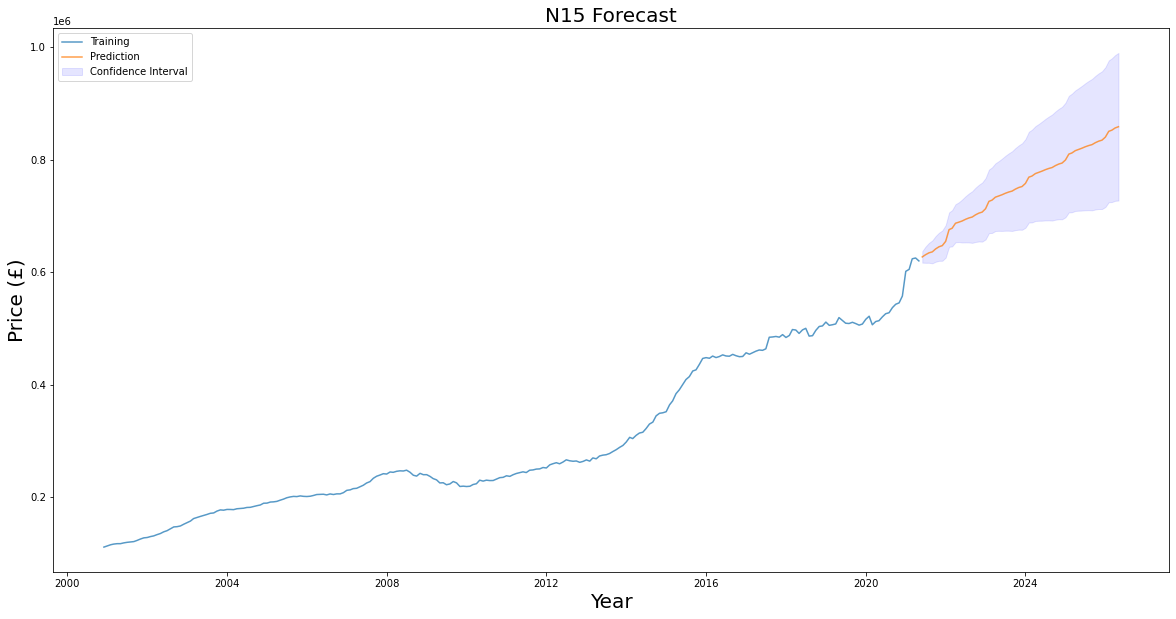

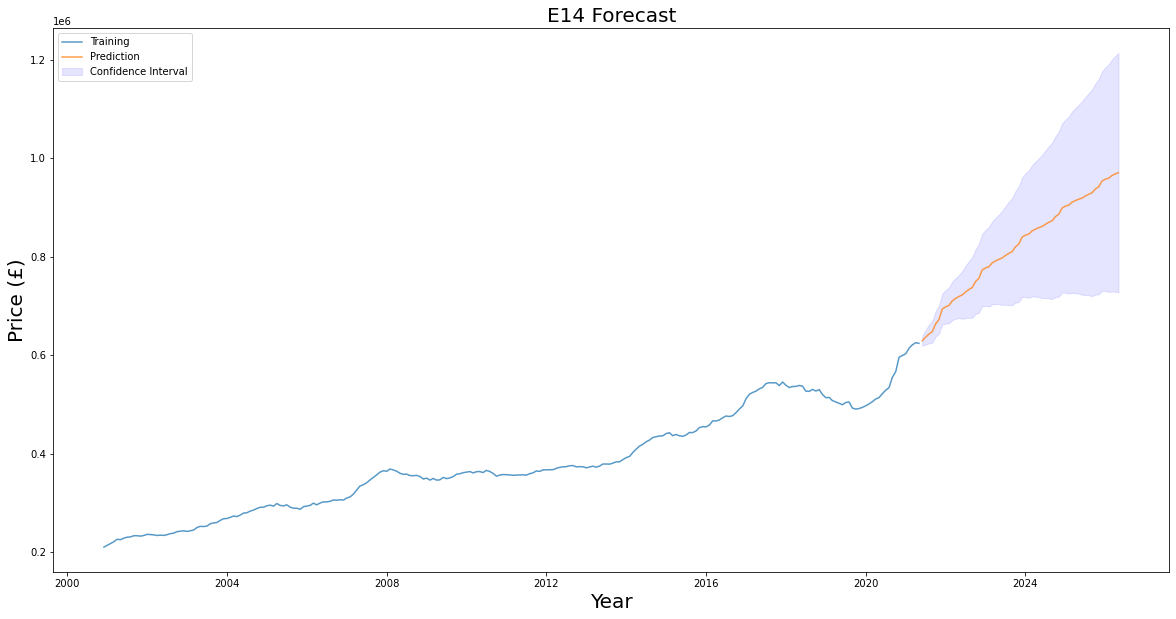

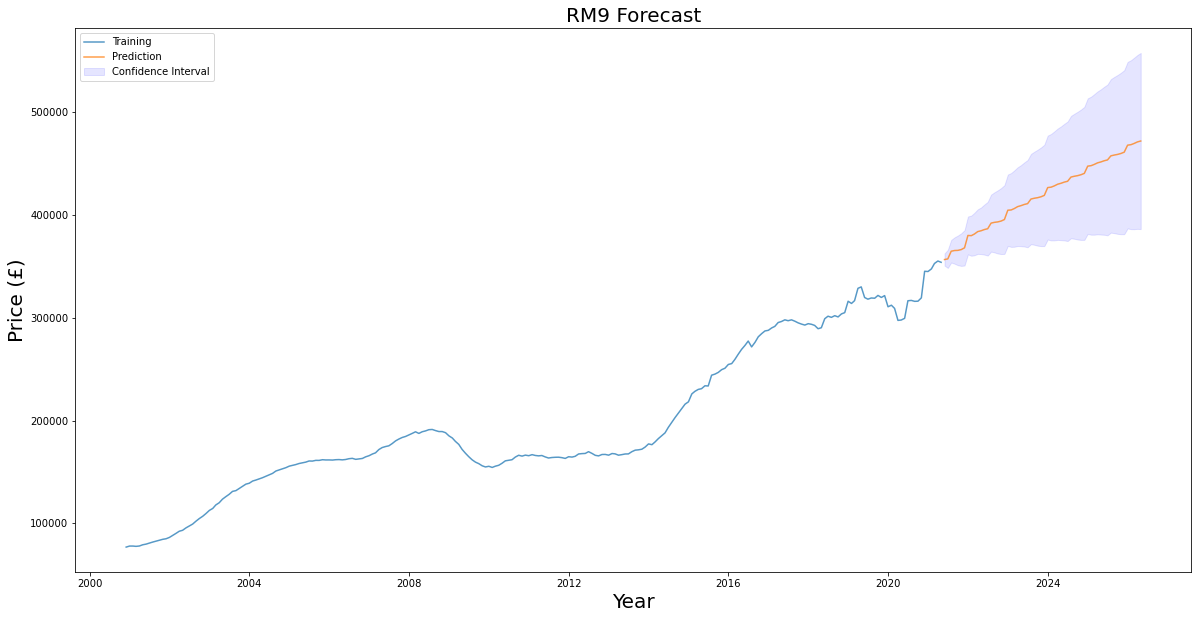

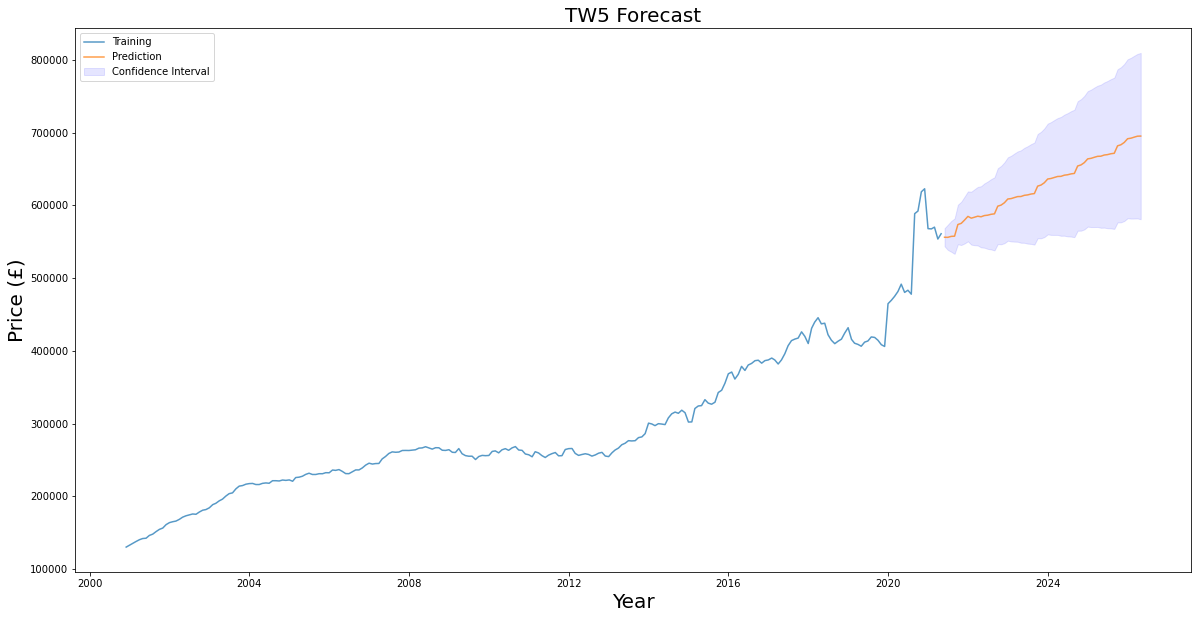

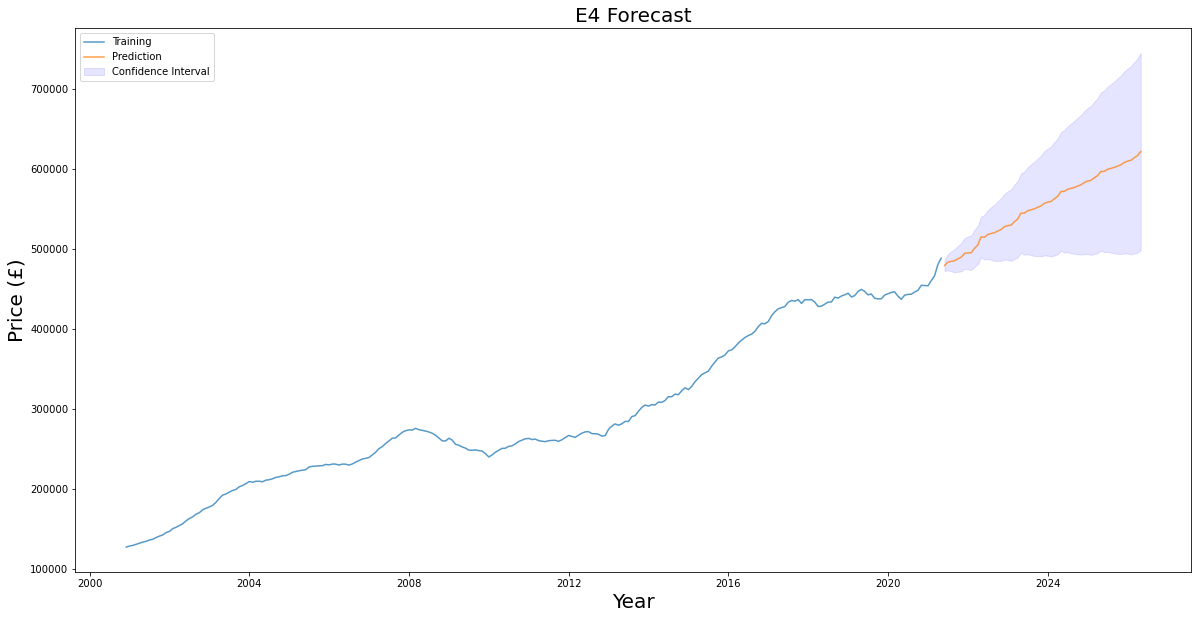

#### What will it cost to buy in these areas?

In [328]:
def get_averages(df1, any_list):
    for i in any_list:
        plt.figure(figsize=(15,8))
        df1[df1['zip']==i].set_index('deed_date')['price_paid'].tail(12).plot()
        plt.title('12 Month Average House Price in {}'.format(i), fontsize = 20)
        plt.annotate('Average Price: £{}'.format(round(df1[df1['zip']==i].set_index('deed_date')['price_paid'].tail(12).mean(),0)), xy=(0.01, 0.95), xycoords='axes fraction', fontsize=16)
        plt.ylabel('House Price (£)', fontsize=14)
        plt.xlabel('Date', fontsize=14)
    


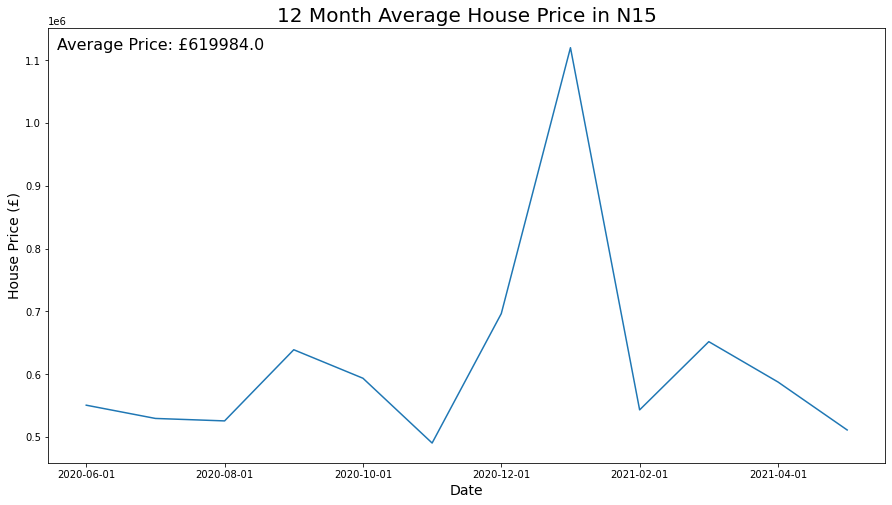

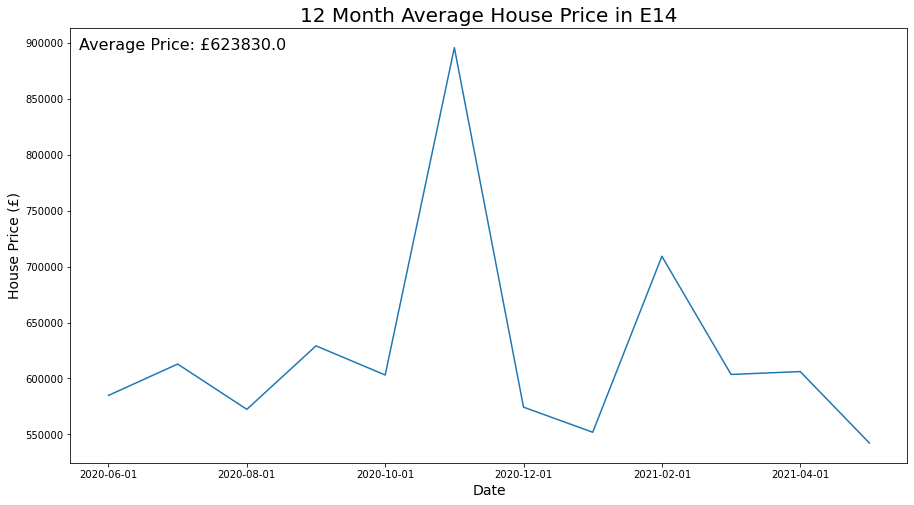

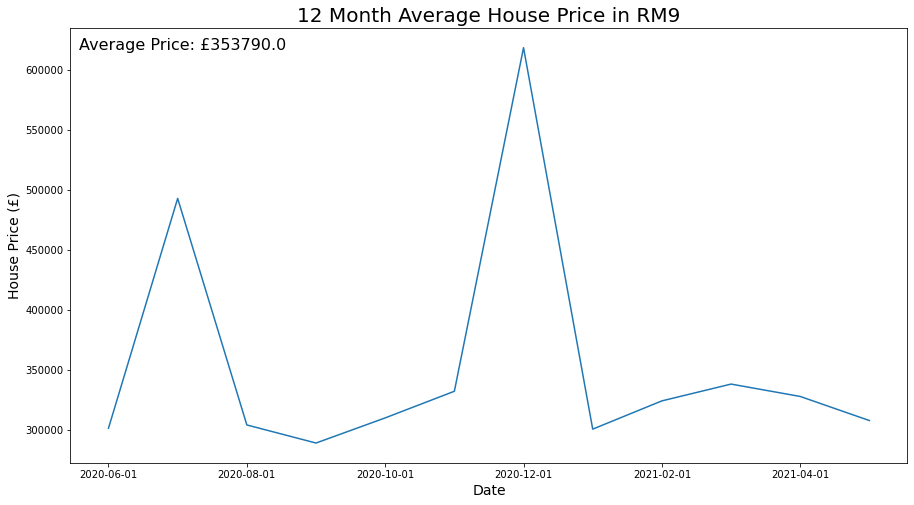

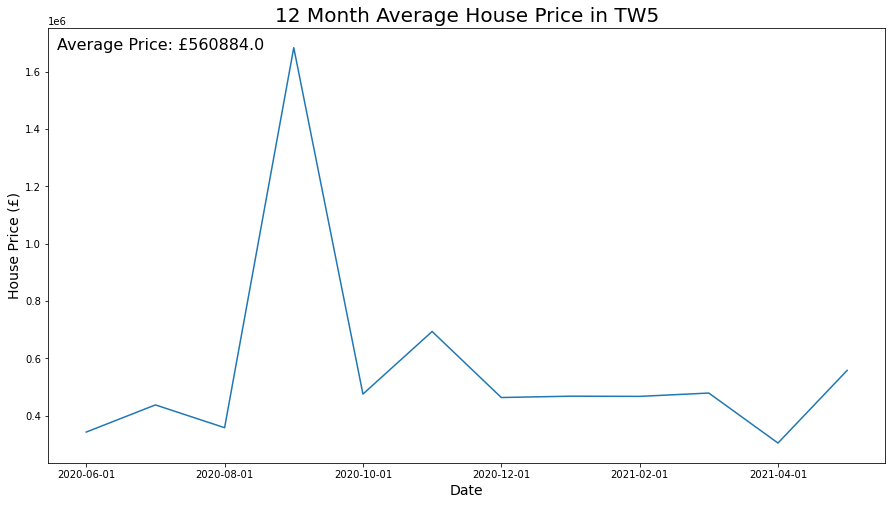

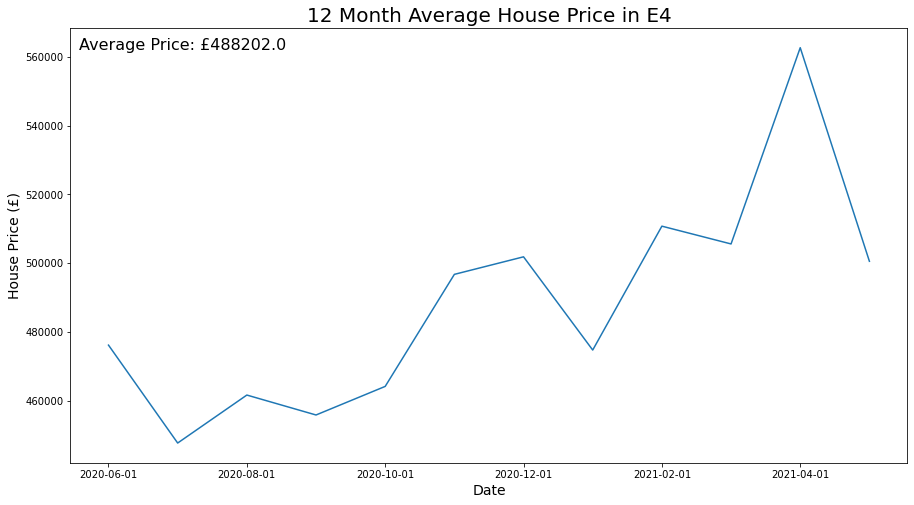

In [329]:
get_averages(df1, top_5_low)

It seems the top 5 low risk investments cover a range of budgets, which for london are reasonable: £350,000 - £625,000

### Neutral Risk

Perhaps the investor is not too concerned with losses and wants to focus on the mid case rate of return. 

<Figure size 720x720 with 0 Axes>

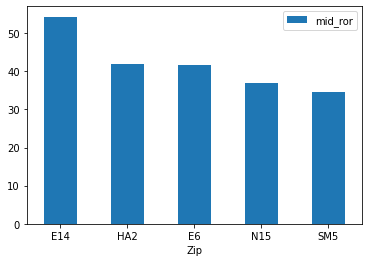

In [373]:
# sort results by descending order on low
top_5_mid = list(summary_forecast.sort_values(by='mid_ror', ascending=False).head()['Zip'].unique())
plt.figure(figsize=(10,10))
ax = summary_forecast.sort_values(by='mid_ror', ascending=False).head().plot.bar(x='Zip', y='mid_ror', rot=0)

In [331]:
top_5_mid

['E14', 'HA2', 'E6', 'N15', 'SM5']

In [332]:
def get_forecasts(any_list):
    for i in any_list:
        df = df1[df1['zip']==i].copy()
        df.drop('zip', axis=1, inplace=True)
    #print(df.head())
        df.columns = ['ds', 'y']
        df.set_index('ds', inplace=True)
        df.index = pd.to_datetime(df.index, format = '%Y/%m/%d')
        df = df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
        df_ave = df.rolling(window=12, center=False).mean()
        with open('{}.pkl'.format(i), 'rb') as pkl:
            new_prediction, new_conf = pickle.load(pkl).predict(n_periods = 60, return_conf_int=True)
        rng = pd.date_range('2021-06-01', periods=60, freq='MS')
        df_ave.index = pd.to_datetime(df_ave.index, format = '%Y/%m/%d')
        new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng)
        new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng)
        plt.figure(figsize=(20,10))
        plt.plot(df_ave, alpha=0.75, label="Training")
        plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
        plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
        plt.legend(loc='upper left')
        plt.xlabel("Year", fontsize=20)
        plt.ylabel("Price (£)", fontsize=20)
        plt.title("{} Forecast".format(i), fontsize=20)
        plt.show()



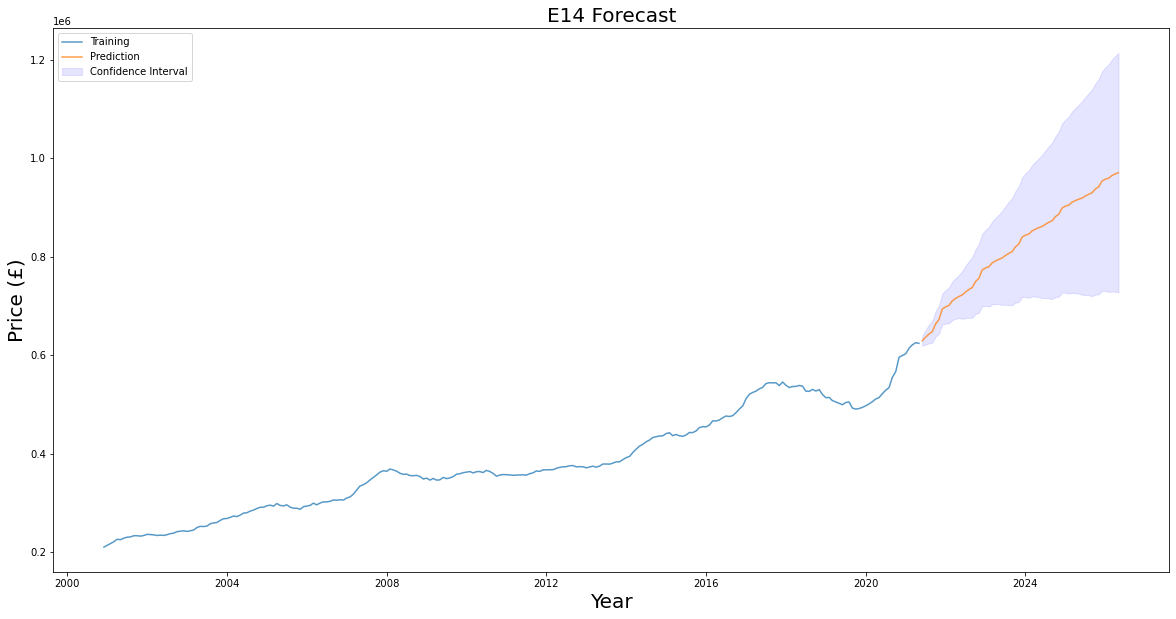

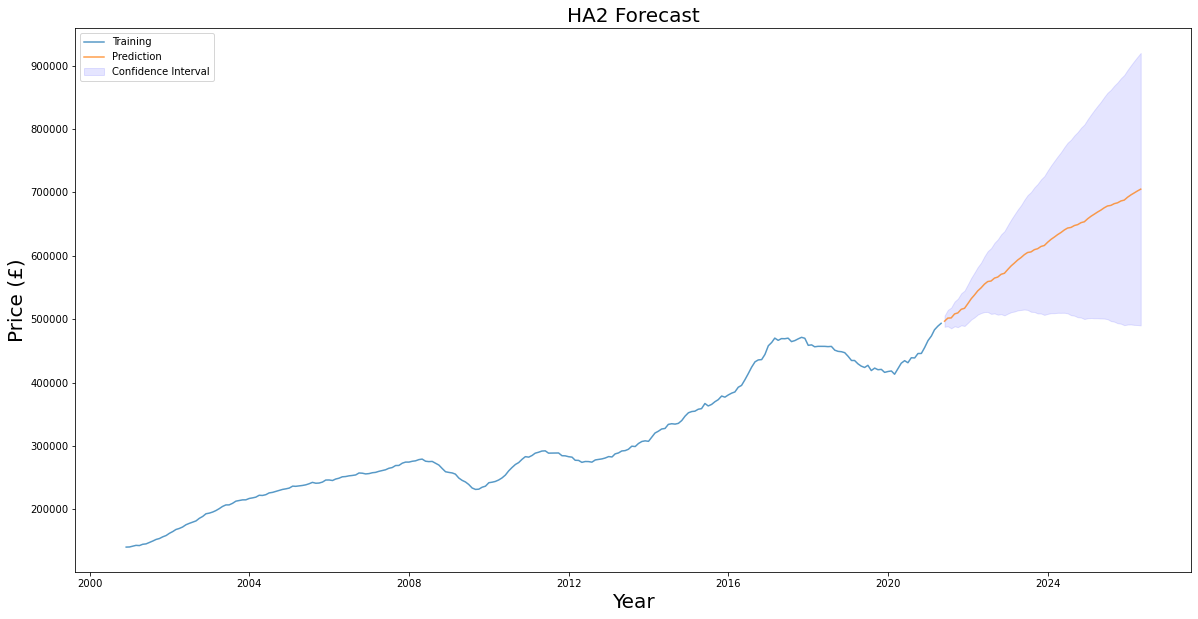

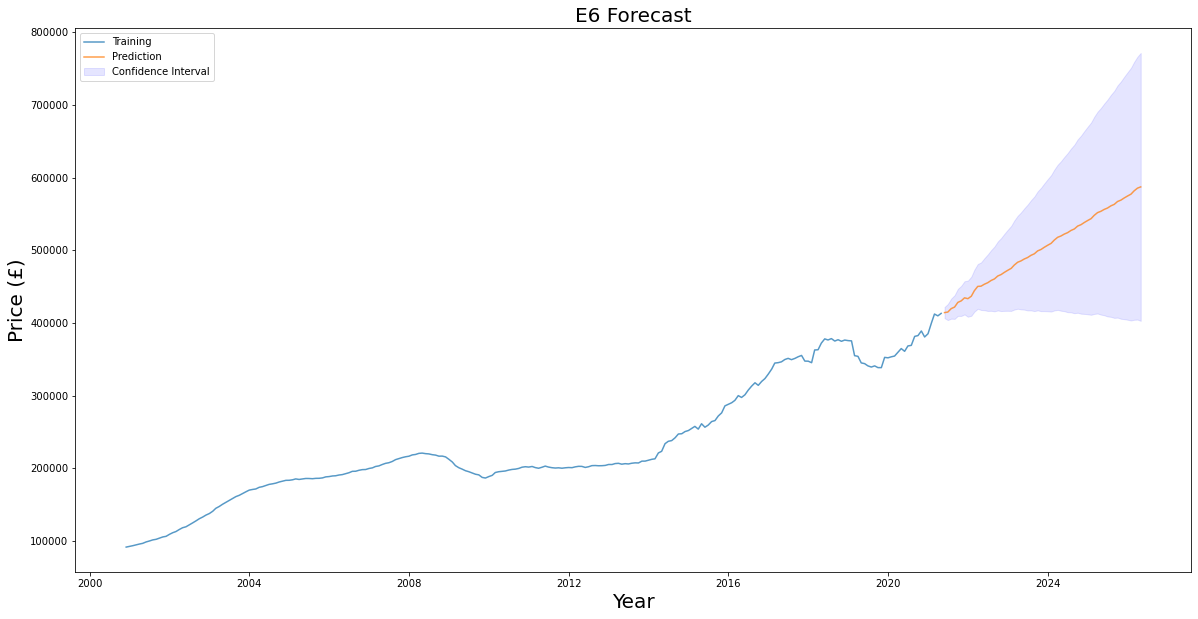

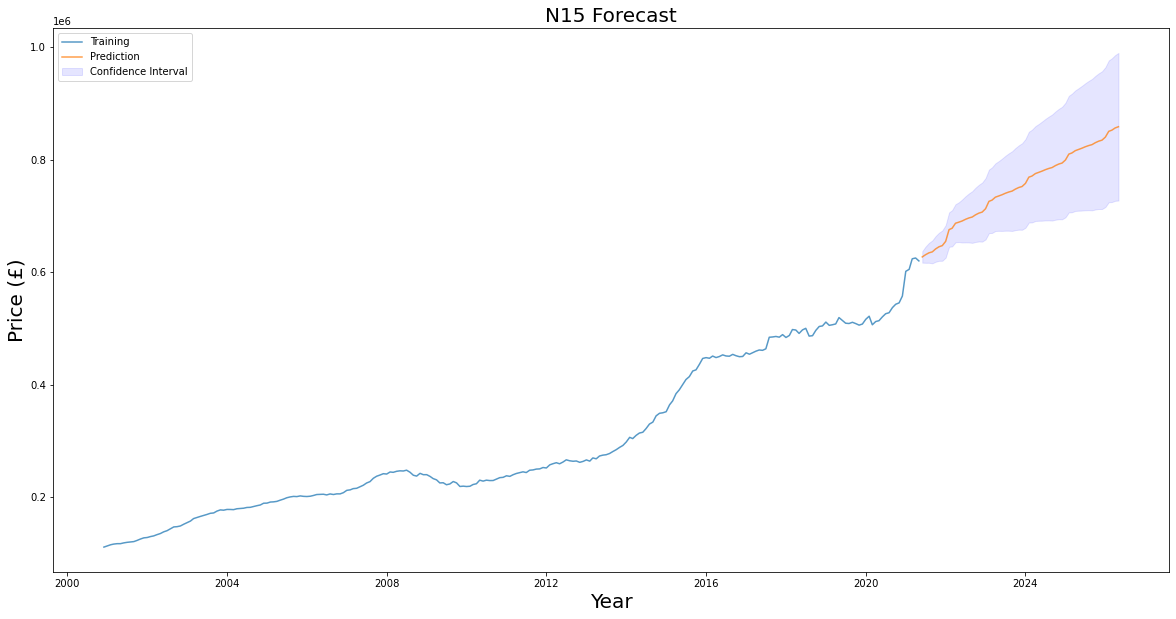

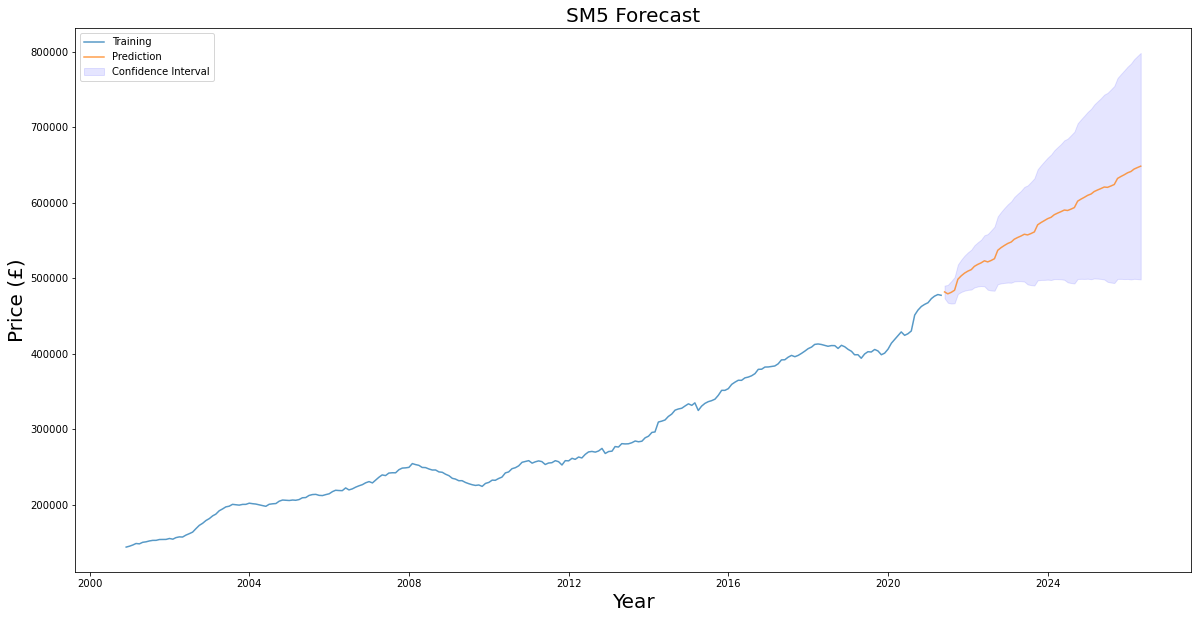

In [333]:
get_forecasts(top_5_mid)

It is not too surprising that there is some double dipping occurring here, some post codes we have seen before, but the mid case does throw up some new results.

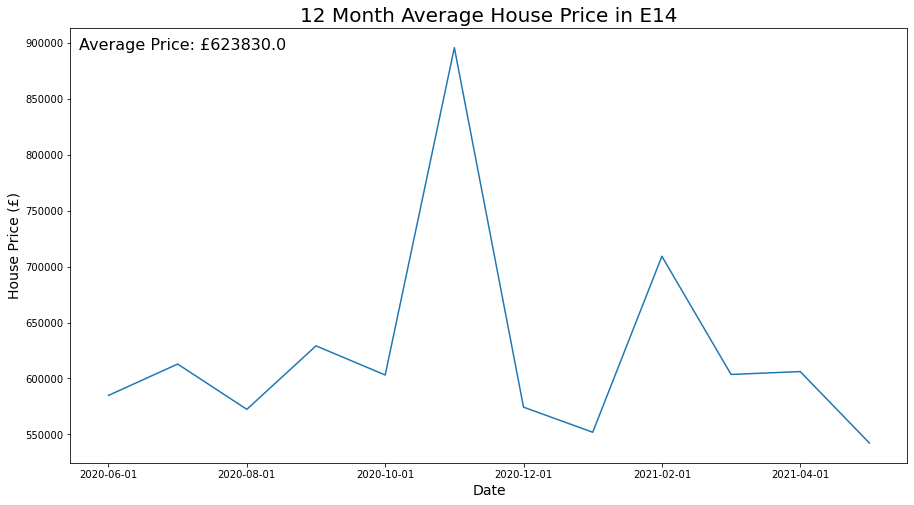

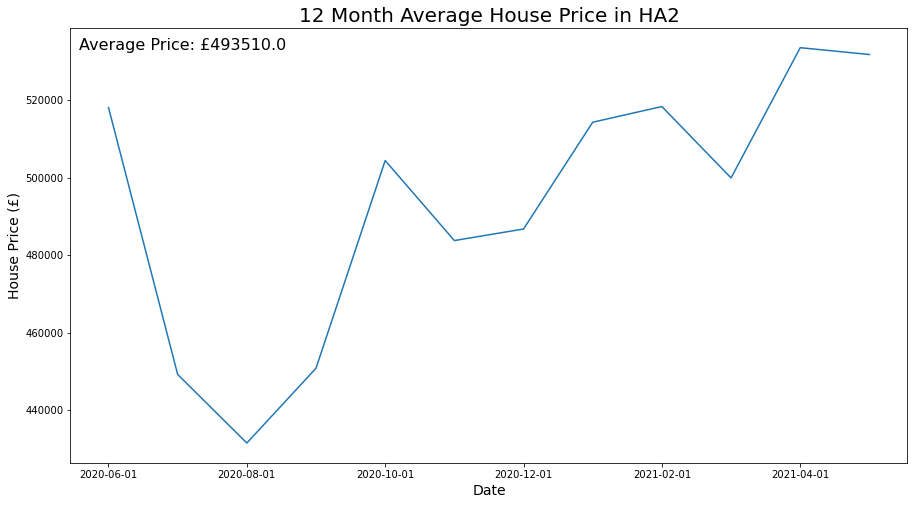

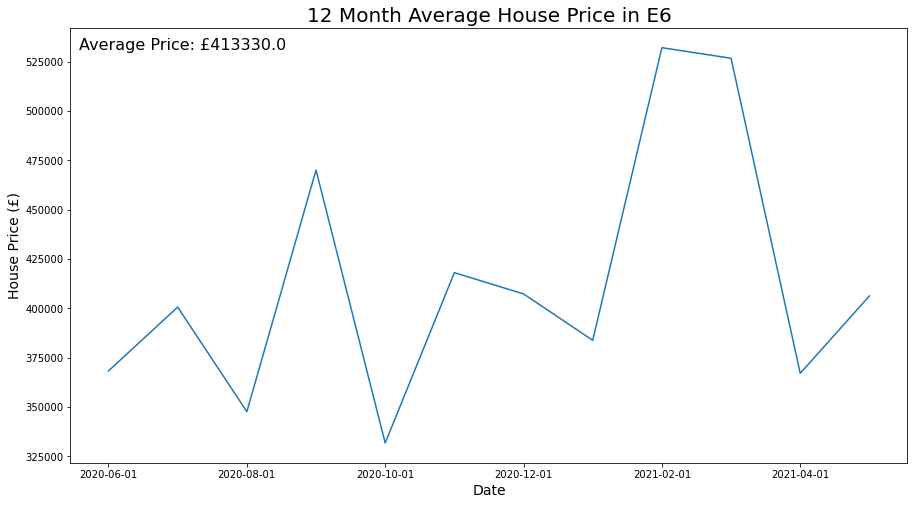

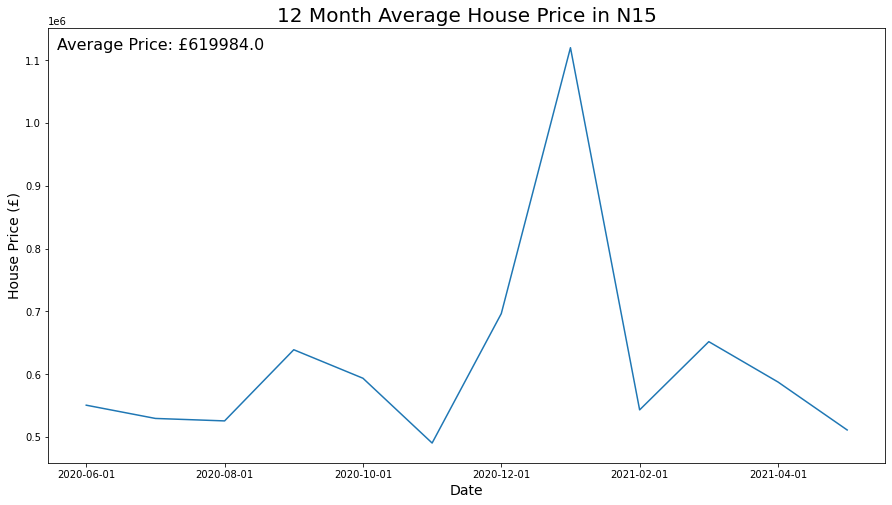

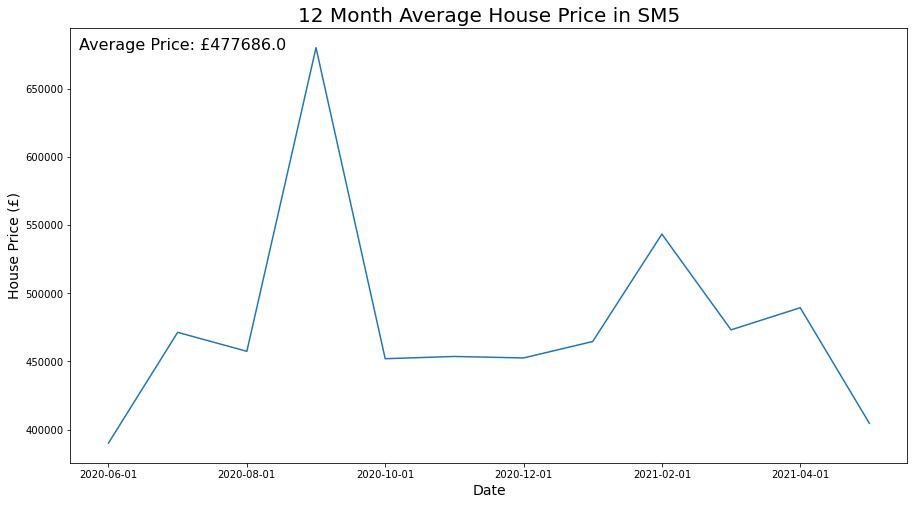

In [334]:
get_averages(df1, top_5_mid)

### High Reward

The client is chasing gains and has little concern for downsides, where would they invest?

In [335]:
top_5_high = list(summary_forecast.sort_values(by='high_ror', ascending=False).head()['Zip'].unique())

In [336]:
top_5_high

['EC4A', 'W1B', 'EC3N', 'WC2B', 'SW8']

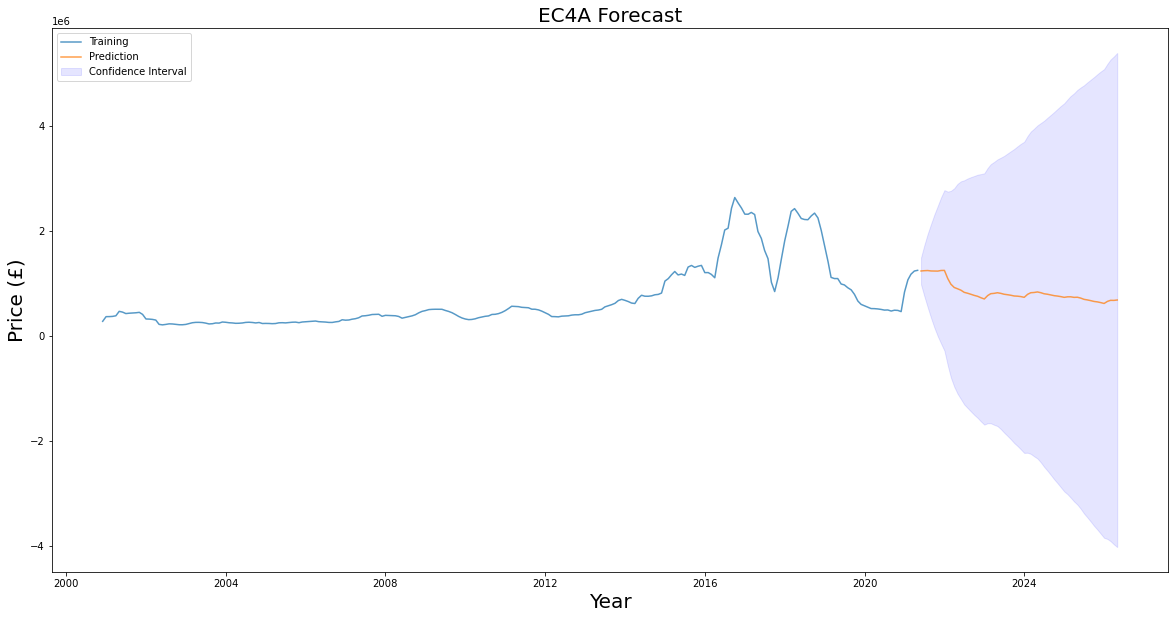

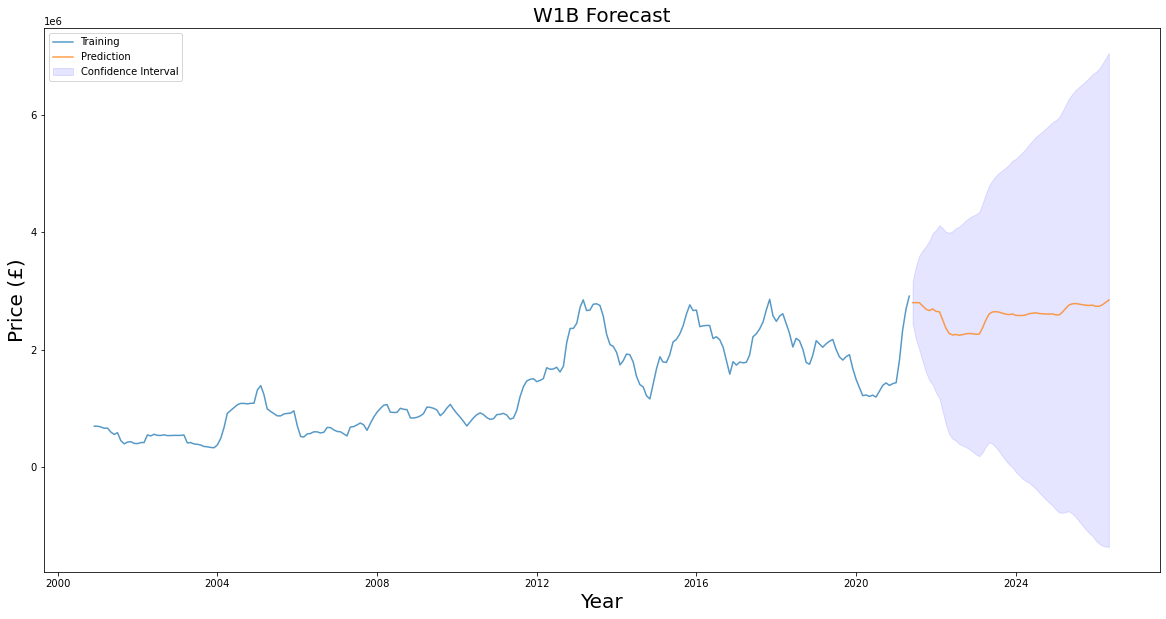

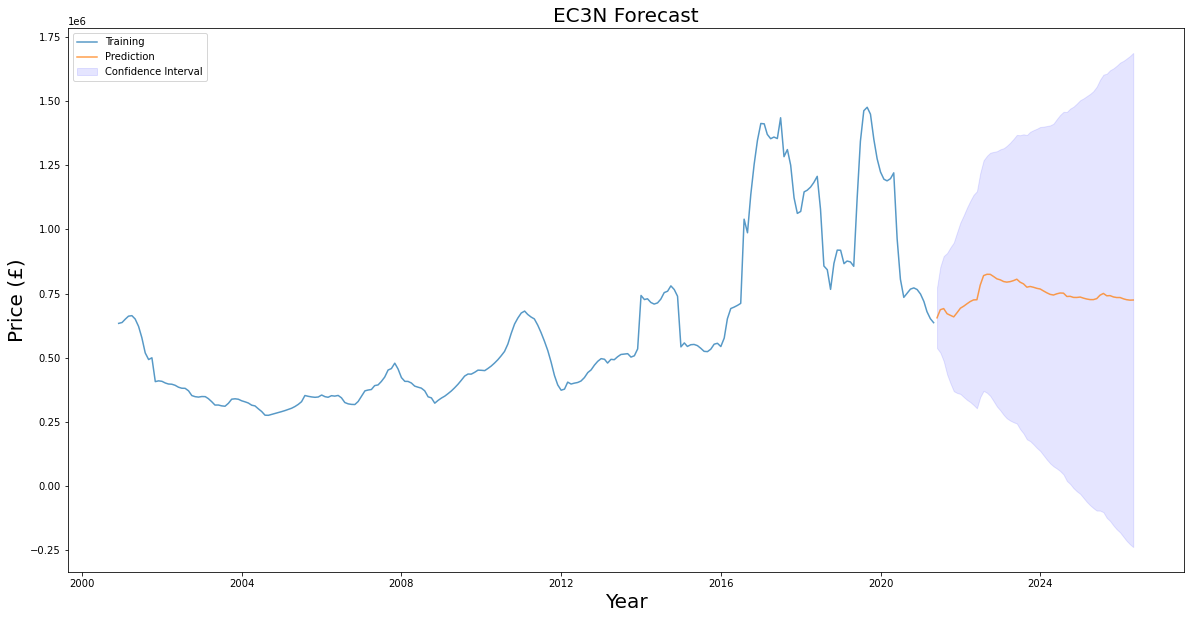

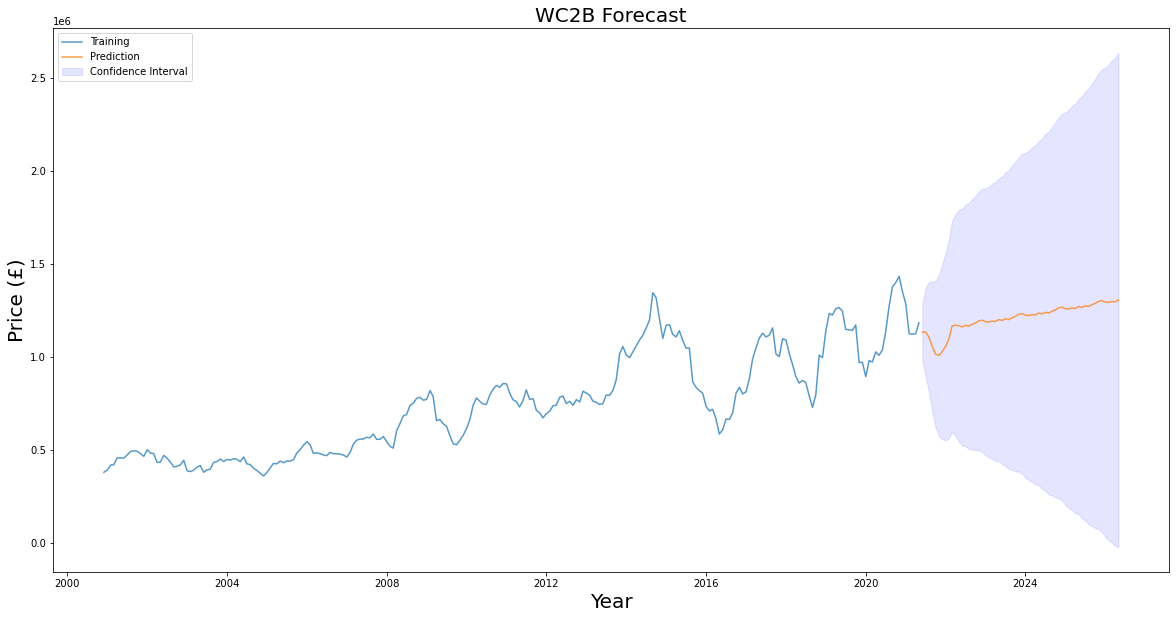

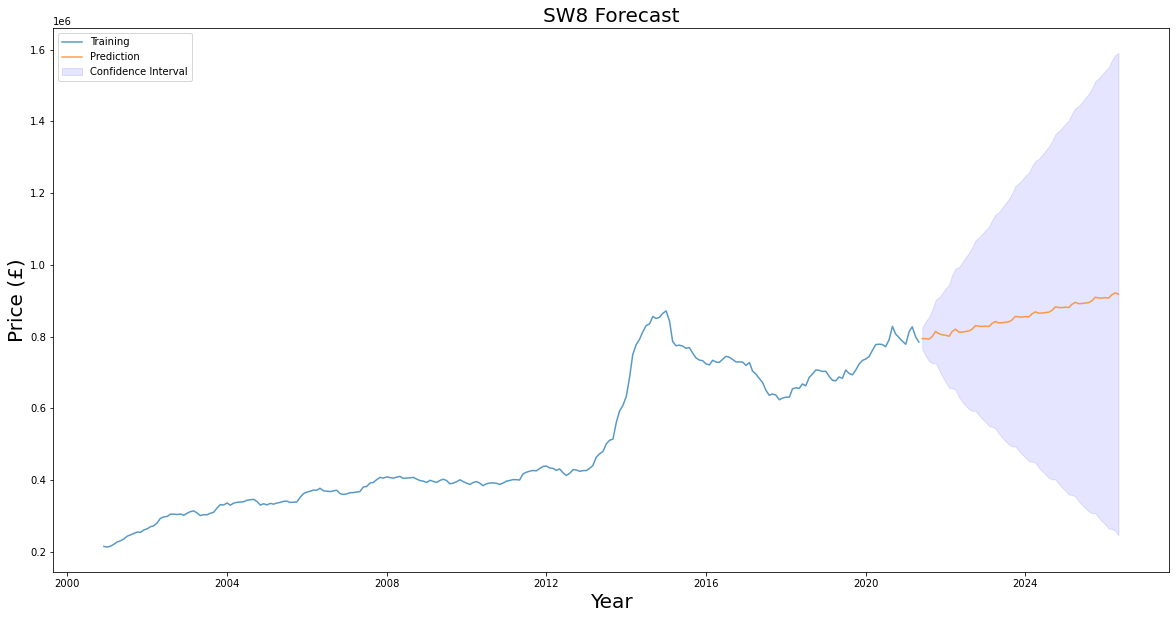

In [337]:
get_forecasts(top_5_high)

These post codes have huge upsides, but they look risky, some of the forecasts indicate the value of your property could be very low. Of course, recent events in the pandemic could be affecting the late time region of the model, this does however reflect the uncertainty in the property market which has seen particularly flats and inner city properties suffer.

In [365]:
bottom_5_mid = list(summary_forecast.sort_values(by='mid_ror', ascending=True)['Zip'].head())

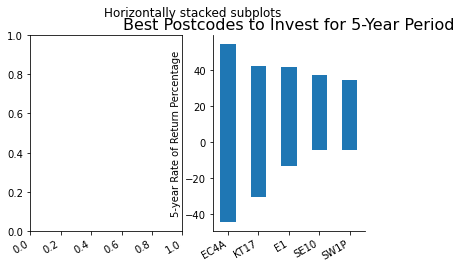

In [368]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')

ax1 = summary_forecast.sort_values(by='mid_ror', ascending=False)['mid_ror'].head().plot.bar(align='center')
ax1.set_ylabel('5-year Rate of Return Percentage')
ax1.spines["top"].set_visible(False)  
ax1.spines["right"].set_visible(False)
ax1.set_xticklabels([i for i in top_5_mid])
ax2 = summary_forecast.sort_values(by='mid_ror', ascending=True)['mid_ror'].head().plot.bar(align='center')
ax2.set_ylabel('5-year Rate of Return Percentage')
ax2.spines["top"].set_visible(False)  
ax2.spines["right"].set_visible(False)
ax2.set_xticklabels([i for i in bottom_5_mid])


y_pos = np.arange(len(top_5_mid))

#plt.axhline(y=0, color='red', alpha=.5)
plt.title('Best Postcodes to Invest for 5-Year Period', fontsize=16)

plt.gcf().autofmt_xdate()
    

## Facebook Prophet Modeling

In [ ]:
# train test split - validation data set separately. 

I will test the modelling phase on one postcode

<AxesSubplot:>

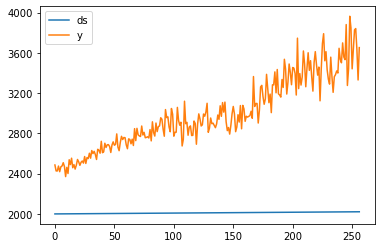

In [109]:
br1 = df1[df1['zip']=='BR1'].copy()
br1.drop('zip', axis=1, inplace=True)
br1.columns = ['ds', 'y']
#br1.set_index('ds', inplace=True)
br1.head()
br1.plot()

In [110]:
br1.tail()

ds              y
252 2021-01-01  678702.567568
253 2021-02-01  683534.651163
254 2021-03-01  606612.500000
255 2021-04-01  496954.545455
256 2021-05-01  614408.333333

In [68]:
br1.describe()

price_paid
count  2.640000e+02
mean   4.475413e+05
std    7.007040e+05
min    1.463465e+05
25%    2.820000e+05
50%    3.519109e+05
75%    4.836741e+05
max    1.063078e+07

In [88]:
from fbprophet import Prophet as proph

In [96]:
br1.head()

ds              y
0 2000-01-01  188510.882353
1 2000-02-01  166975.060606
2 2000-03-01  166774.318182
3 2000-04-01  184542.528090
4 2000-05-01  164167.565789

In [100]:
br1.tail()

ds              y
259 2021-08-01  656187.500000
260 2021-09-01  598966.666667
261 2021-10-01  584625.000000
262 2021-11-01  688750.000000
263 2021-12-01  438041.666667

In [111]:
Model = proph(interval_width=0.95)

In [112]:
# Fit the timeseries to Model
Model.fit(br1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [113]:
future_dates = Model.make_future_dataframe(periods=48, freq='MS')
future_dates.tail()

ds
300 2025-01-01
301 2025-02-01
302 2025-03-01
303 2025-04-01
304 2025-05-01

In [114]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2000-01-01  176987.249841   91940.078116  252461.218218  176987.249841   
1 2000-02-01  178553.974410  103136.807894  264746.439605  178553.974410   
2 2000-03-01  180019.619974  120897.831395  275123.941302  180019.619974   
3 2000-04-01  181586.344542   83538.342106  241181.541169  181586.344542   
4 2000-05-01  183102.529608   88045.396250  239923.142100  183102.529608   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  176987.249841    -6076.324614          -6076.324614          -6076.324614   
1  178553.974410     4657.863359           4657.863359           4657.863359   
2  180019.619974    17766.019234          17766.019234          17766.019234   
3  181586.344542   -17964.502727         -17964.502727         -17964.502727   
4  183102.529608   -18479.197364         -18479.197364         -18479.197364   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0  -6076.324614  -6076.324614  -6076.324614                   0.0   
1   4657.863359   4657.863359   4657.863359                   0.0   
2  17766.019234  17766.019234  17766.019234                   0.0   
3 -17964.502727 -17964.502727 -17964.502727                   0.0   
4 -18479.197364 -18479.197364 -18479.197364                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper           yhat  
0                         0.0                         0.0  170910.925227  
1                         0.0                         0.0  183211.837769  
2                         0.0                         0.0  197785.639208  
3                         0.0                         0.0  163621.841816  
4                         0.0                         0.0  164623.332245

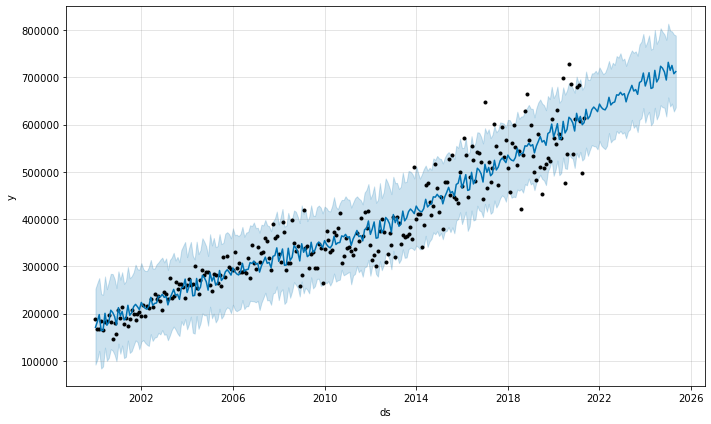

In [115]:
Model.plot(forecast, uncertainty=True)
plt.show()

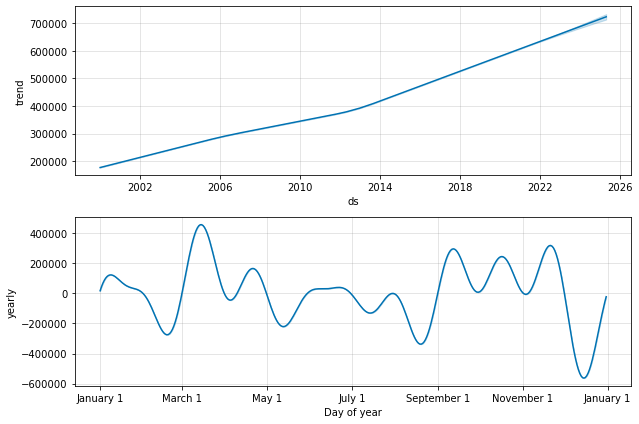

In [116]:
# Plot model components 
Model.plot_components(forecast)
plt.show()

In [118]:
import itertools
p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
import statsmodels.api as sm
#Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(co2,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [124]:
br1_sar = br1.set_index('ds')
br1_sar = br1_sar['y']

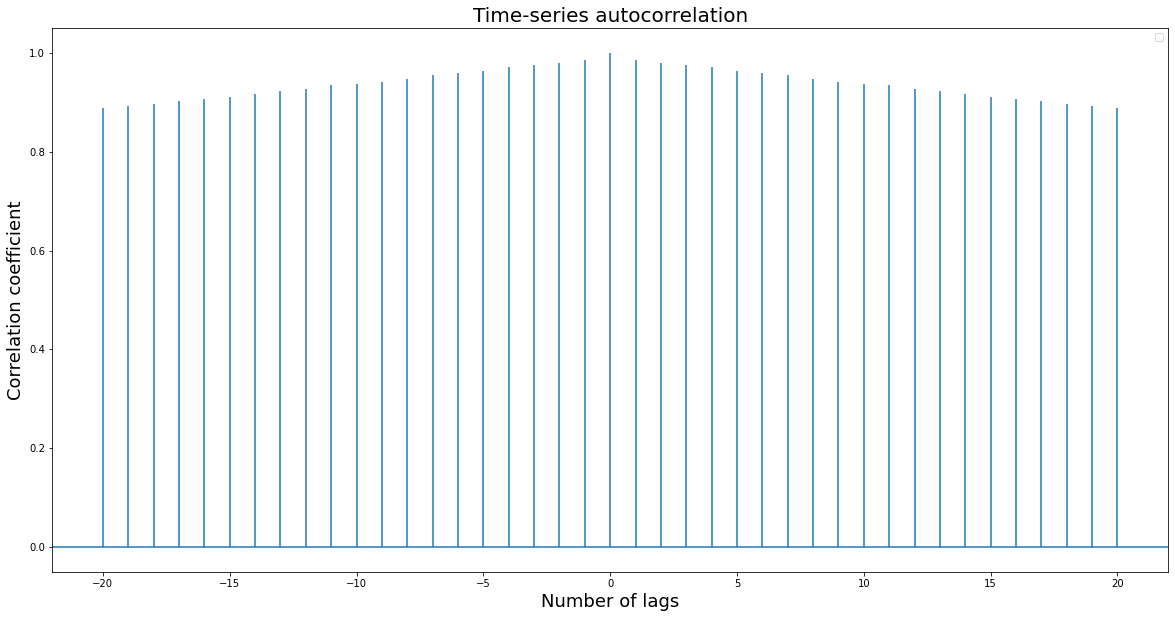

In [129]:
plt.figure(figsize=(20,10))
plt.acorr(x=br1_sar.values,maxlags=20)
plt.xlabel("Number of lags", fontsize='18')
plt.ylabel("Correlation coefficient", fontsize='18')
plt.title("Time-series autocorrelation", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [126]:
br1_sar.values

array([188510.88235294, 166975.06060606, 166774.31818182, 184542.52808989,
       164167.56578947, 181809.62121212, 184954.59756098, 196793.84615385,
       183029.31372549, 146346.54237288, 179883.43283582, 157578.48148148,
       207478.52830189, 189995.45454545, 213111.75789474, 178452.84313725,
       189863.83333333, 173522.67045455, 187611.4025974 , 208478.40659341,
       199864.09090909, 187232.27848101, 198268.17647059, 202974.89361702,
       195444.11764706, 219150.        , 194113.74358974, 215636.54639175,
       211584.11290323, 231111.35869565, 213169.40659341, 240920.64655172,
       229915.05376344, 237977.1375    , 226433.92553191, 208491.2804878 ,
       245587.36111111, 241985.19607843, 231179.63768116, 274469.86567164,
       233014.48717949, 236218.46875   , 267410.29411765, 252035.54455446,
       261870.51724138, 262326.06410256, 255531.88888889, 233893.31578947,
       260990.66176471, 272423.8       , 260159.02597403, 263272.42307692,
       301249.80769231, 2

In [123]:
br1_sar

y
ds                       
2000-01-01  188510.882353
2000-02-01  166975.060606
2000-03-01  166774.318182
2000-04-01  184542.528090
2000-05-01  164167.565789
...                   ...
2021-01-01  678702.567568
2021-02-01  683534.651163
2021-03-01  606612.500000
2021-04-01  496954.545455
2021-05-01  614408.333333

[257 rows x 1 columns]

<AxesSubplot:xlabel='ds'>

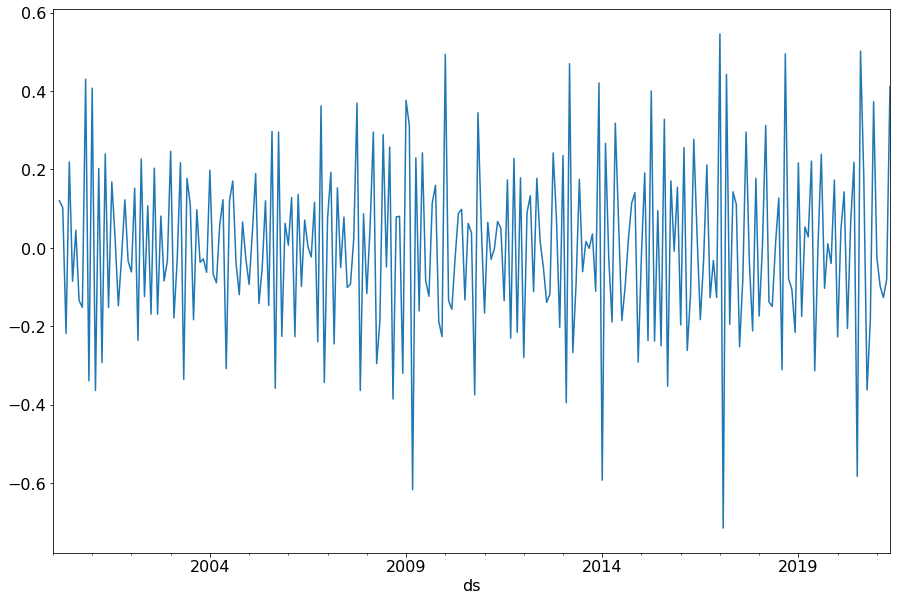

In [191]:
diff = np.log(br1_sar).diff().diff()
diff.plot()

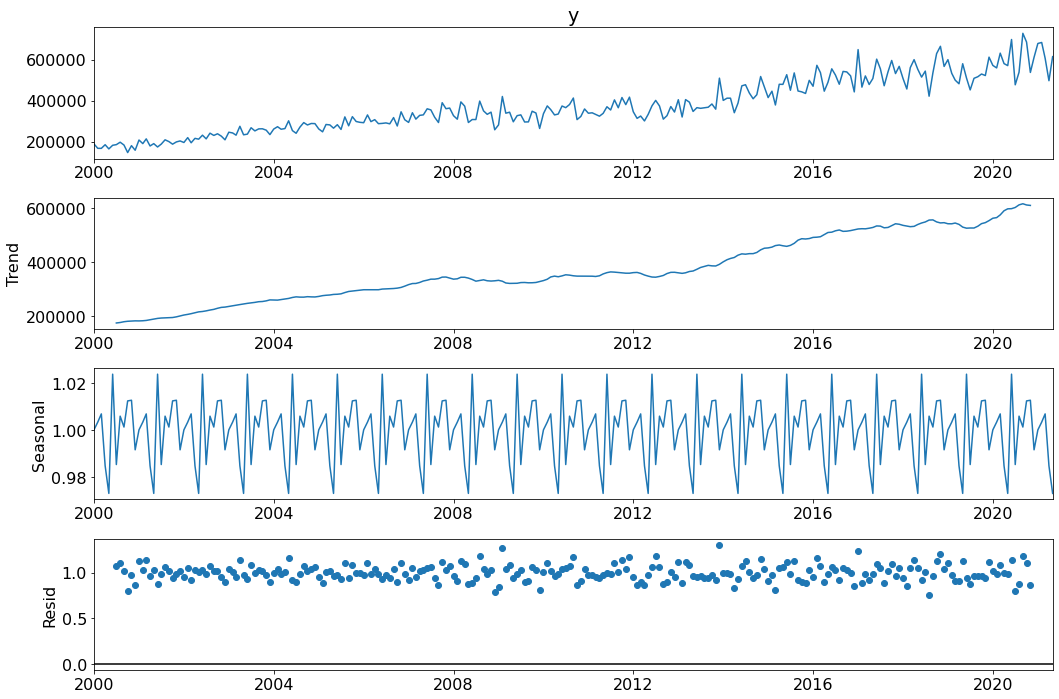

In [205]:
# seasonal orders and seaonal differencing, take only seasonal data from decomp.seasonal
# revert to study group,

results = seasonal_decompose(br1_sar,two_sided = True, model='multiplicative')
results.plot()
plt.show()

In [207]:
#train-test split
train_df = br1_sar[br1_sar.index < '2017-12-01']
test_df = br1_sar[(br1_sar.index >= '2017-12-01') & (br1_sar.index < '2019-01-01')]
val_df = br1_sar[(br1_sar.index >= '2019-01-01') & (br1_sar.index < '2021-05-01')]

In [208]:
cbrt_train =  np.cbrt(train_df)


In [209]:
from statsmodels.tsa.stattools import adfuller

(0.6437096171689164,
 0.98864488145156,
 10,
 204,
 {'1%': -3.462818103072159,
  '5%': -2.8758145932936805,
  '10%': -2.574378674548251},
 4754.043742286747)

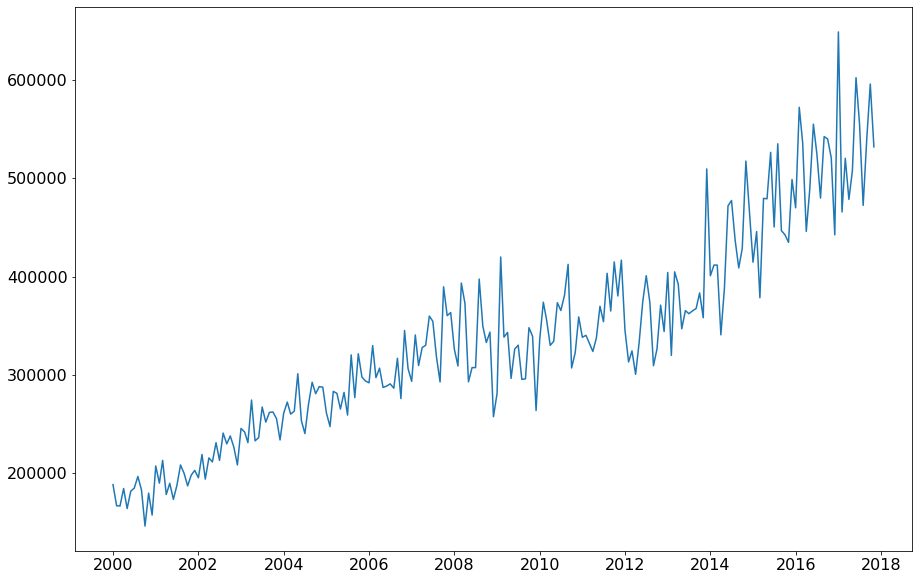

In [210]:
plt.plot(train_df)
adfuller(train_df)

(-12.261002900397507,
 1.4912302057185956e-19,
 4,
 209,
 {'1%': -4.0027517721652925,
  '5%': -3.4317085320958416,
  '10%': -3.139513599307244},
 4760.025183984892)

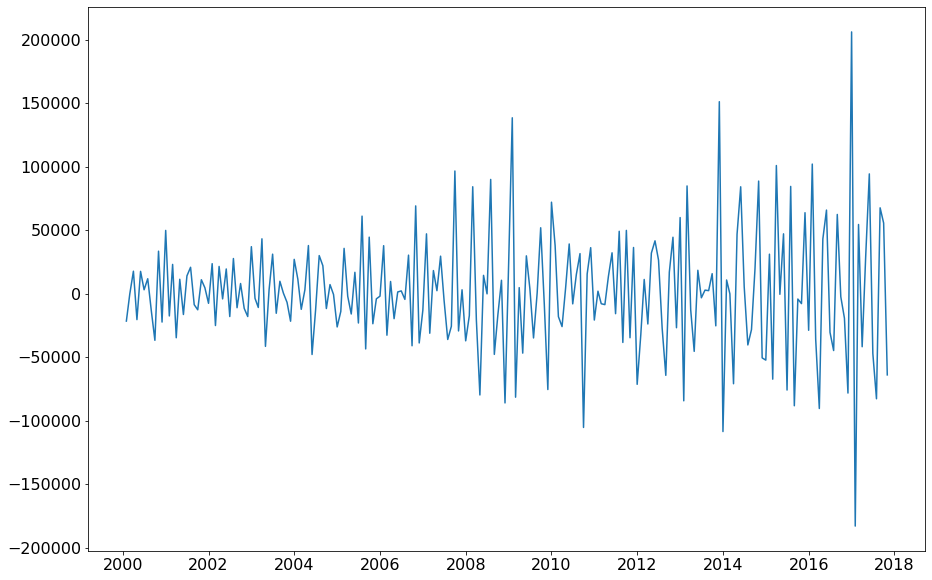

In [211]:
train_diff = train_df.diff(1).dropna()
plt.plot(train_diff)
adresults = adfuller(train_diff, autolag = 'BIC', regression = 'ct')
adresults

(-12.148642213455489,
 2.2273355629539834e-19,
 4,
 209,
 {'1%': -4.0027517721652925,
  '5%': -3.4317085320958416,
  '10%': -3.139513599307244},
 927.3803772056856)

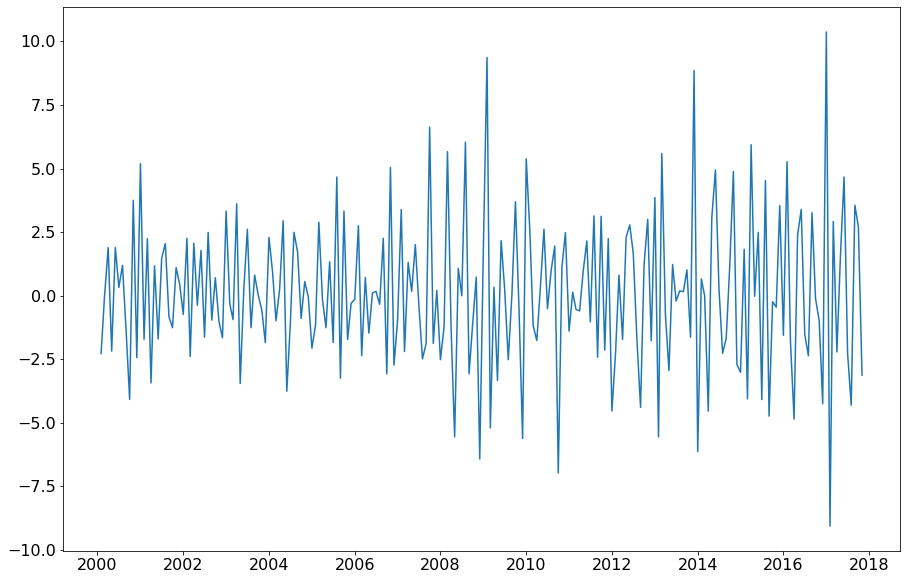

In [212]:
train_diff_cbrt = np.cbrt(train_df).diff(1).dropna()
plt.plot(train_diff_cbrt)
adresults = adfuller(train_diff_cbrt, autolag = 'BIC', regression = 'ct')
adresults

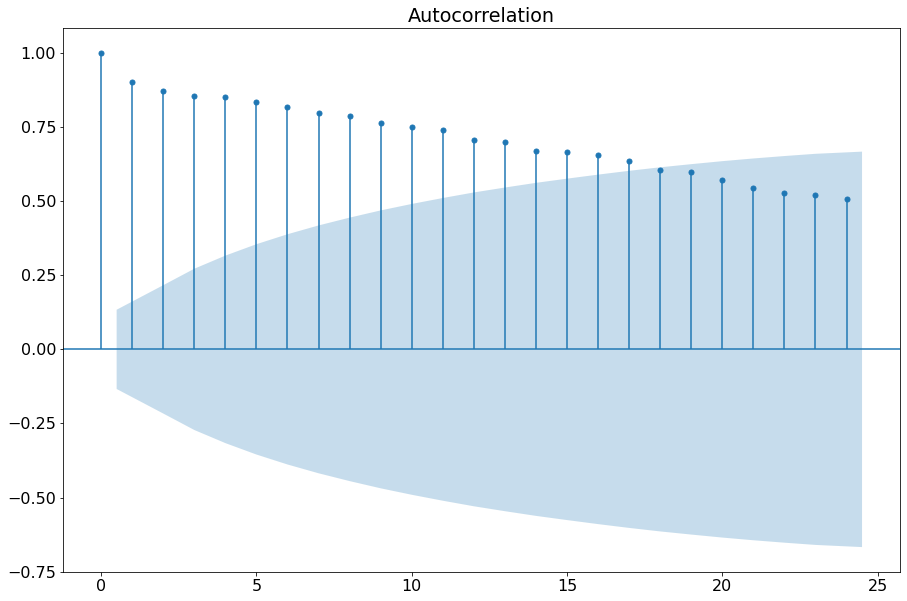

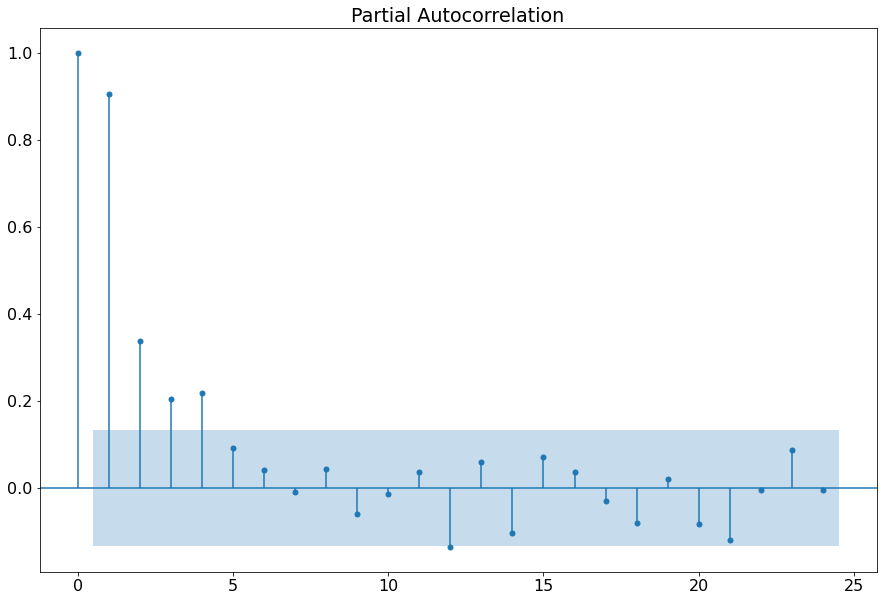

In [213]:
plot_acf(cbrt_train)
plot_pacf(cbrt_train)
plt.show()

In [217]:
def mean_percent_error(y_test, y_hat):
    from math import e
    error = np.abs(y_test - y_hat)
    percent_error = error/(y_test + e)
    mean_percent_error = percent_error.sum() / len(y_test)
    return mean_percent_error

In [2]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

NameError: name 'fc' is not defined

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


simple arima mean percent error:  0.12926302352498478


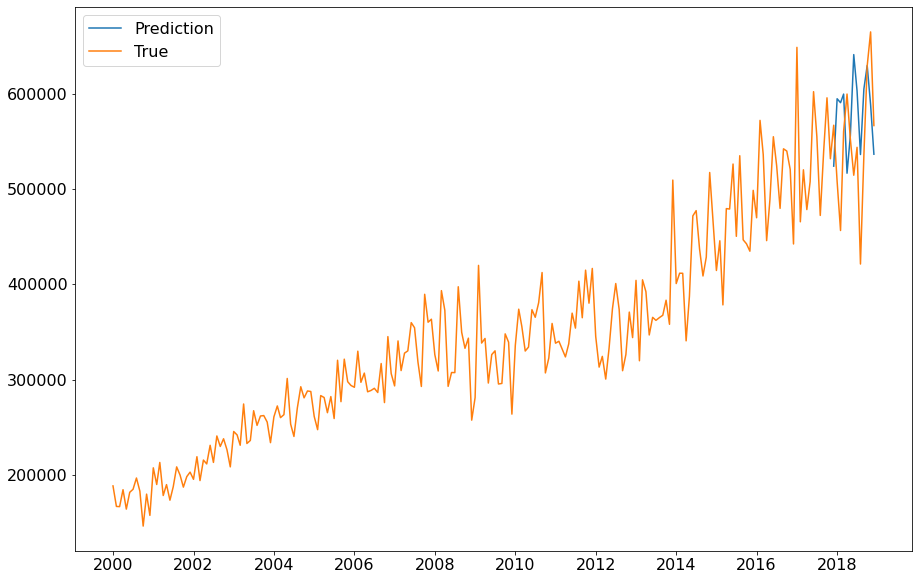

In [237]:

arimamodel = SARIMAX(cbrt_train, order = (4,1,0), seasonal_order = (1,1,0,12))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test_df))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test_df,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(br1_sar[br1_sar.index < '2019-01-01'], label = 'True')
plt.legend()
plt.show()

In [229]:
test_results = pd.DataFrame(columns = ['MPE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(cbrt_train, order =(p,d,q), seasonal_order = (P,D,Q,12))
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(test_df))
                        yhat = yhat**3
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},12)'
                        mpe = mean_percent_error(test_df,yhat)
                        print(f'trying {ind}, MPE = {mpe}')
                        test_results.loc[ind,'MPE'] = mpe

test_results.min()

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (0,1,0,12), MPE = 0.12753356173833683
trying order = (0,1,0), seasonal_order = (0,1,1,12), MPE = 0.09744471956951317


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (0,1,2,12), MPE = 0.09493109348103618


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (0,1,3,12), MPE = 0.09512516270032319
trying order = (0,1,0), seasonal_order = (0,2,0,12), MPE = 0.2579896772490006


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-pa

trying order = (0,1,0), seasonal_order = (0,2,1,12), MPE = 0.12764995389272005


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (0,2,2,12), MPE = 0.11988546659318627


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (0,2,3,12), MPE = 0.1173633646755604


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,1,0,12), MPE = 0.1314412429007314


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,1,1,12), MPE = 0.0959220420445758


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,1,2,12), MPE = 0.09514399353107451


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,1,3,12), MPE = 0.09781665731951347


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,2,0,12), MPE = 0.21335075564879505


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,2,1,12), MPE = 0.13549406109771142


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,2,2,12), MPE = 0.1175497056112197


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (1,2,3,12), MPE = 0.12756265675440007
trying order = (0,1,0), seasonal_order = (2,1,0,12), MPE = 0.11323188857230518

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,1,1,12), MPE = 0.09541441028743576


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,1,2,12), MPE = 0.0983780090684229


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,1,3,12), MPE = 0.09745935064085437


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,2,0,12), MPE = 0.15268042007737515


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,2,1,12), MPE = 0.11442223781532596


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,2,2,12), MPE = 0.12099287723231698


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (2,2,3,12), MPE = 0.1261838255181418


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,1,0,12), MPE = 0.11311555392601183


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,1,1,12), MPE = 0.0948375804653376


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,1,2,12), MPE = 0.0978242608594746


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,1,3,12), MPE = 0.09805956137595286


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,2,0,12), MPE = 0.1499066647248966


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,2,1,12), MPE = 0.11357507412432821


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,2,2,12), MPE = 0.12221106293286349


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,0), seasonal_order = (3,2,3,12), MPE = 0.1257961319924841
trying order = (0,1,1), seasonal_order = (0,1,0,12), MPE = 0.12694632844975767


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,1,1,12), MPE = 0.10038875663110357


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,1,2,12), MPE = 0.10154177988761284


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,1,3,12), MPE = 0.10056947793467713


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,2,0,12), MPE = 0.19766710390055595


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,2,1,12), MPE = 0.12828102203945219


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,2,2,12), MPE = 0.11505972441802913


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (0,2,3,12), MPE = 0.11044505653507455


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,1,0,12), MPE = 0.1247364792552715


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,1,1,12), MPE = 0.10150656883144141


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,1,2,12), MPE = 0.09768743421977856


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,1,3,12), MPE = 0.10180977062908697


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,2,0,12), MPE = 0.17725145211476845


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,2,1,12), MPE = 0.12498699620731359


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,2,2,12), MPE = 0.10986264717083814


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (1,2,3,12), MPE = 0.11663936043148186


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,1,0,12), MPE = 0.11782021550687759


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,1,1,12), MPE = 0.10070014453974994


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,1,2,12), MPE = 0.10150071934689017


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,1,3,12), MPE = 0.10947232929871557


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,2,0,12), MPE = 0.14589274086536674


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,2,1,12), MPE = 0.11694343973966431


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,2,2,12), MPE = 0.10987729890704866


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (2,2,3,12), MPE = 0.11060618372766655


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,1,0,12), MPE = 0.1224885643303406


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,1,1,12), MPE = 0.1014383228605147


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,1,2,12), MPE = 0.10144533089115125


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,1,3,12), MPE = 0.10133742481447501


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,2,0,12), MPE = 0.15193774748739594


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,2,1,12), MPE = 0.11785219557858931


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,2,2,12), MPE = 0.10732440052294022


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,1), seasonal_order = (3,2,3,12), MPE = 0.11137079288948029


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,1,0,12), MPE = 0.12694994830635598


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,1,1,12), MPE = 0.10033675416451418


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,1,2,12), MPE = 0.10147098733752169


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,1,3,12), MPE = 0.10051600703537802


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,2,0,12), MPE = 0.19737703967146325


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,2,1,12), MPE = 0.1281886658300982


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,2,2,12), MPE = 0.11499670457733156


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (0,2,3,12), MPE = 0.11045070369339352


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,1,0,12), MPE = 0.12476110083015188


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,1,1,12), MPE = 0.1014285048650725


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,1,2,12), MPE = 0.09769471196230026


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,1,3,12), MPE = 0.10174034265754382


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,2,0,12), MPE = 0.1766957732076942


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,2,1,12), MPE = 0.12497451268409286


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,2,2,12), MPE = 0.10989105056258468


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (1,2,3,12), MPE = 0.1169249034664829


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,1,0,12), MPE = 0.11768867535333127


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,1,1,12), MPE = 0.10064276727734539


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,1,2,12), MPE = 0.10139841515717424


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,1,3,12), MPE = 0.10940211668009706


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,2,0,12), MPE = 0.14474660688051608


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,2,1,12), MPE = 0.1167520473469794
trying order = (0,1,2), seasonal_order = (2,2,2,12), MPE = 0.10989535518602607


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (2,2,3,12), MPE = 0.11060727847472943


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,1,0,12), MPE = 0.122804223587092


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,1,1,12), MPE = 0.1014095113449393


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,1,2,12), MPE = 0.10141466565687536


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,1,3,12), MPE = 0.10134553677399467


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,2,0,12), MPE = 0.15319465029315


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,2,1,12), MPE = 0.11796087658433335


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,2,2,12), MPE = 0.11276483792883973


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,2), seasonal_order = (3,2,3,12), MPE = 0.11137621377850661


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


trying order = (0,1,3), seasonal_order = (0,1,0,12), MPE = 0.12681202118430135


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,1,1,12), MPE = 0.0993602128734319


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,1,2,12), MPE = 0.10152644973060673


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,1,3,12), MPE = 0.10076971885859834


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,2,0,12), MPE = 0.19734276598821582


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,2,1,12), MPE = 0.1281668497721084


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,2,2,12), MPE = 0.11647139108712995


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (0,2,3,12), MPE = 0.10979513112554762


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,1,0,12), MPE = 0.12480676565096484


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,1,1,12), MPE = 0.10141875487054869


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,1,2,12), MPE = 0.09846057366410149


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,1,3,12), MPE = 0.10176934993139884


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,2,0,12), MPE = 0.1769870861165866


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,2,1,12), MPE = 0.12494186963467063


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,2,2,12), MPE = 0.11031133371400435


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (1,2,3,12), MPE = 0.11816798639150508


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,1,0,12), MPE = 0.11803196393256984


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,1,1,12), MPE = 0.10098427817382835


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,1,2,12), MPE = 0.10153194036857452


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,1,3,12), MPE = 0.09847227057653114


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,2,0,12), MPE = 0.14507357587911052


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,2,1,12), MPE = 0.11703590376338666


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,2,2,12), MPE = 0.10980501279424058


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (2,2,3,12), MPE = 0.11001444309115521


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,1,0,12), MPE = 0.12253295193258172


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,1,1,12), MPE = 0.10161418479658968


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,1,2,12), MPE = 0.10162860920829928


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,1,3,12), MPE = 0.11010613719132235


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,2,0,12), MPE = 0.15097624715742042


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,2,1,12), MPE = 0.11770442111117715


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,2,2,12), MPE = 0.10754717543972078


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,1,3), seasonal_order = (3,2,3,12), MPE = 0.11226656026905991


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,1,0,12), MPE = 0.45515605202715054


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,1,1,12), MPE = 0.6088407725121887


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,1,2,12), MPE = 0.6605143690968382


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,1,3,12), MPE = 0.6603567852548309


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,2,0,12), MPE = 0.5112563412441609


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,2,1,12), MPE = 0.42205902073684654


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,2,2,12), MPE = 0.6220762738505083


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (0,2,3,12), MPE = 0.6574609826846971


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,1,0,12), MPE = 0.42208548929684964


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,1,1,12), MPE = 0.6428051364443974


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,1,2,12), MPE = 0.658526330066776


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,1,3,12), MPE = 0.5932309667171466
trying order = (0,2,0), seasonal_order = (1,2,0,12), MPE = 0.8180168730332231


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,2,1,12), MPE = 0.3931648188862755


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,2,2,12), MPE = 0.6503706368210475


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (1,2,3,12), MPE = 0.535181342699875


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,1,0,12), MPE = 0.6933509620497499


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,1,1,12), MPE = 0.6667105207139147


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,1,2,12), MPE = 0.5694415256912851


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,1,3,12), MPE = 0.5742366807168545


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,2,0,12), MPE = 0.4473800011007269


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


trying order = (0,2,0), seasonal_order = (2,2,1,12), MPE = 0.6540643102967508


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


KeyboardInterrupt: 

In [238]:

test_results.sort_values(by = 'MPE').head(25)

MPE
order = (0,1,0), seasonal_order = (3,1,1,12)  0.0948376
order = (0,1,0), seasonal_order = (0,1,2,12)  0.0949311
order = (0,1,0), seasonal_order = (0,1,3,12)  0.0951252
order = (0,1,0), seasonal_order = (1,1,2,12)   0.095144
order = (0,1,0), seasonal_order = (2,1,1,12)  0.0954144
order = (0,1,0), seasonal_order = (1,1,1,12)   0.095922
order = (0,1,0), seasonal_order = (0,1,1,12)  0.0974447
order = (0,1,0), seasonal_order = (2,1,3,12)  0.0974594
order = (0,1,1), seasonal_order = (1,1,2,12)  0.0976874
order = (0,1,2), seasonal_order = (1,1,2,12)  0.0976947
order = (0,1,0), seasonal_order = (1,1,3,12)  0.0978167
order = (0,1,0), seasonal_order = (3,1,2,12)  0.0978243
order = (0,1,0), seasonal_order = (3,1,3,12)  0.0980596
order = (0,1,0), seasonal_order = (2,1,2,12)   0.098378
order = (0,1,3), seasonal_order = (1,1,2,12)  0.0984606
order = (0,1,3), seasonal_order = (2,1,3,12)  0.0984723
order = (0,1,3), seasonal_order = (0,1,1,12)  0.0993602
order = (0,1,2), seasonal_order = (0,1,1,12)   0.100337
order = (0,1,1), seasonal_order = (0,1,1,12)   0.100389
order = (0,1,2), seasonal_order = (0,1,3,12)   0.100516
order = (0,1,1), seasonal_order = (0,1,3,12)   0.100569
order = (0,1,2), seasonal_order = (2,1,1,12)   0.100643
order = (0,1,1), seasonal_order = (2,1,1,12)     0.1007
order = (0,1,3), seasonal_order = (0,1,3,12)    0.10077
order = (0,1,3), seasonal_order = (2,1,1,12)   0.100984

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



simple arima mean percent error:  2021-06-01 00:00:00    0.0
2021-07-01 00:00:00    0.0
2021-08-01 00:00:00    0.0
2021-09-01 00:00:00    0.0
2021-10-01 00:00:00    0.0
2021-11-01 00:00:00    0.0
2021-12-01 00:00:00    0.0
2022-01-01 00:00:00    0.0
2022-02-01 00:00:00    0.0
2022-03-01 00:00:00    0.0
2022-04-01 00:00:00    0.0
2022-05-01 00:00:00    0.0
2022-06-01 00:00:00    0.0
y                      0.0
dtype: float64


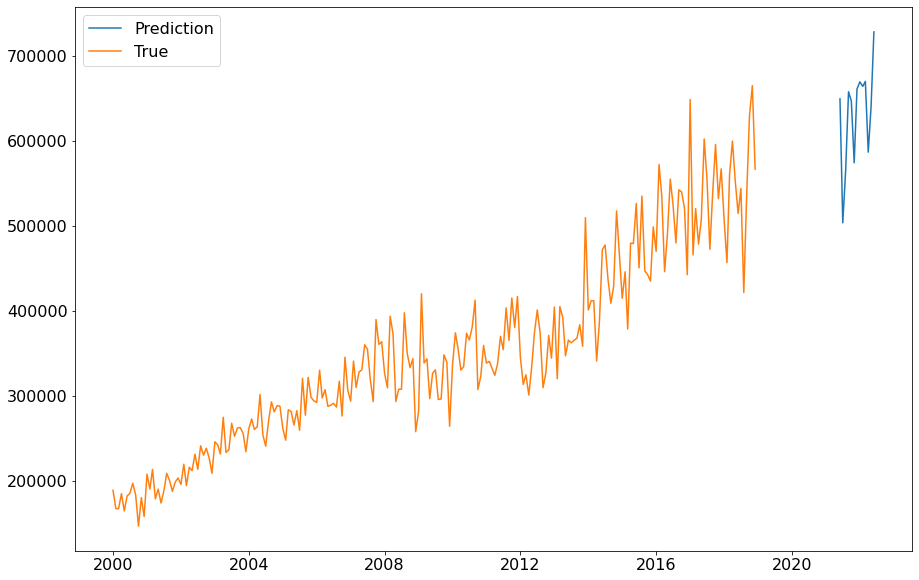

In [296]:

arimamodel = SARIMAX(cbrt_train, order = (4,1,2), seasonal_order = (1,1,0,12))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test_df))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test_df,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(br1_sar[br1_sar.index < '2019-01-01'], label = 'True')
plt.legend()
plt.show()

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



simple arima mean percent error:  0.23317983419824587


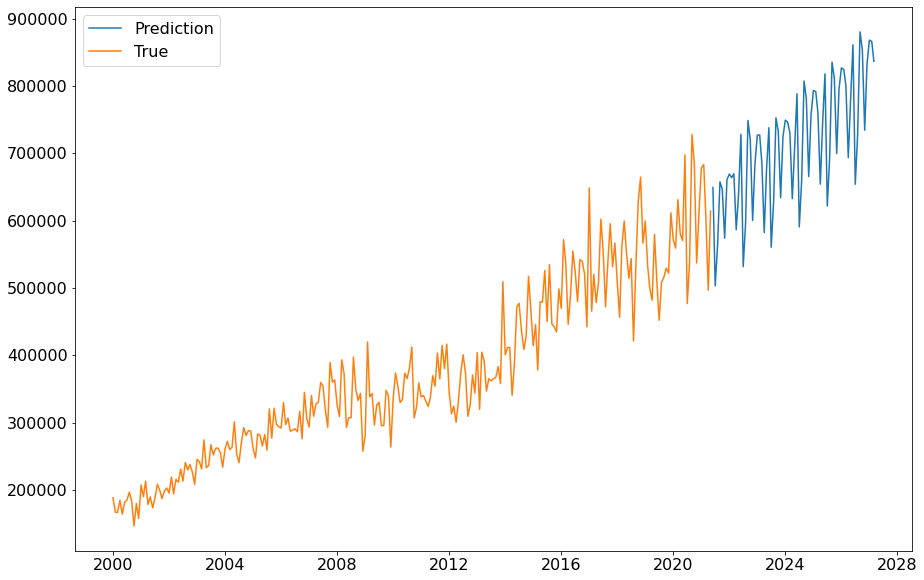

In [297]:

arimamodel = SARIMAX(cbrt_train2, order = (4,1,2), seasonal_order = (1,1,0,12))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test2))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test2,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(br1_sar, label = 'True')
plt.legend()
plt.show()

In [ ]:
compare with rolling mean and add confidence intervals - don't worry about capturing the variance in forecast.
explore seasonality - is it across all zips?
general recommendation according to risk profile of individual
rolling STD
compare rolling mean prediction vs rolling mean of actual

Time to try the model on another series

In [280]:
br2 = df1[df1['zip']=='BR2'].copy()
br2.drop('zip', axis=1, inplace=True)
br2.columns = ['ds', 'y']
br2.set_index('ds', inplace=True)
br2 = br2.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)

cbrt_train3 = np.cbrt(br2)

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



simple arima mean percent error:  0.1155586383528


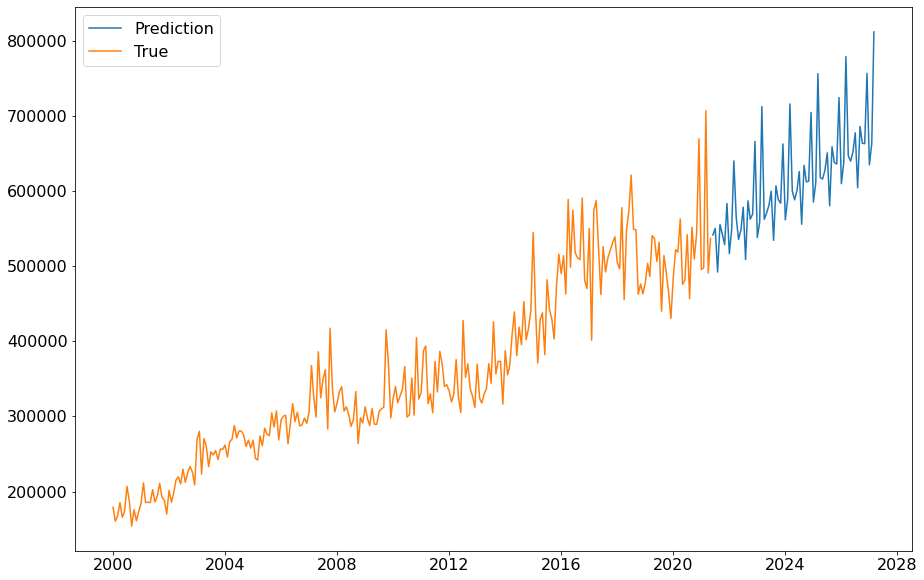

In [281]:
arimamodel = SARIMAX(cbrt_train3, order = (4,1,2), seasonal_order = (1,1,0,12))
fit_model = arimamodel.fit()
yhat = fit_model.forecast(len(test2))
# undo the cube root in order to compare to the test data
yhat = yhat**3
mpe = mean_percent_error(test2,yhat)
print('simple arima mean percent error: ', mpe)
plt.plot(yhat, label = 'Prediction')
plt.plot(br2, label = 'True')
plt.legend()
plt.show()

In [ ]:
#Creating a test date set of future dates
br1_test_future=br1_sar_test
br1_test_future.index=br1_test_future.index+pd.DateOffset(years=5)
y_hat_avg_future = br1_test_future.copy()
fit_future = sm.tsa.statespace.SARIMAX(br1_sar, order=(0, 1, 1),seasonal_order=(1,1,1,12)).fit()
y_hat_avg_future['SARIMA'] = fit2.predict(start=br1_test_future.index[0],end=br1_test_future.index[-1])
plt.figure(figsize=(20,10))
plt.plot( br1_sar, label='Train')
plt.plot(y_hat_avg_future['SARIMA'], label='Predicted', color='g')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([br1_sar_train.index[0], br1_test_future.index[-1]]))
plt.ylabel("Mean Price (£)", fontsize='18')
plt.title("Future predictions with SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

<ipython-input-131-05a703390047>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposistion=seasonal_decompose(br1_sar,freq=12)


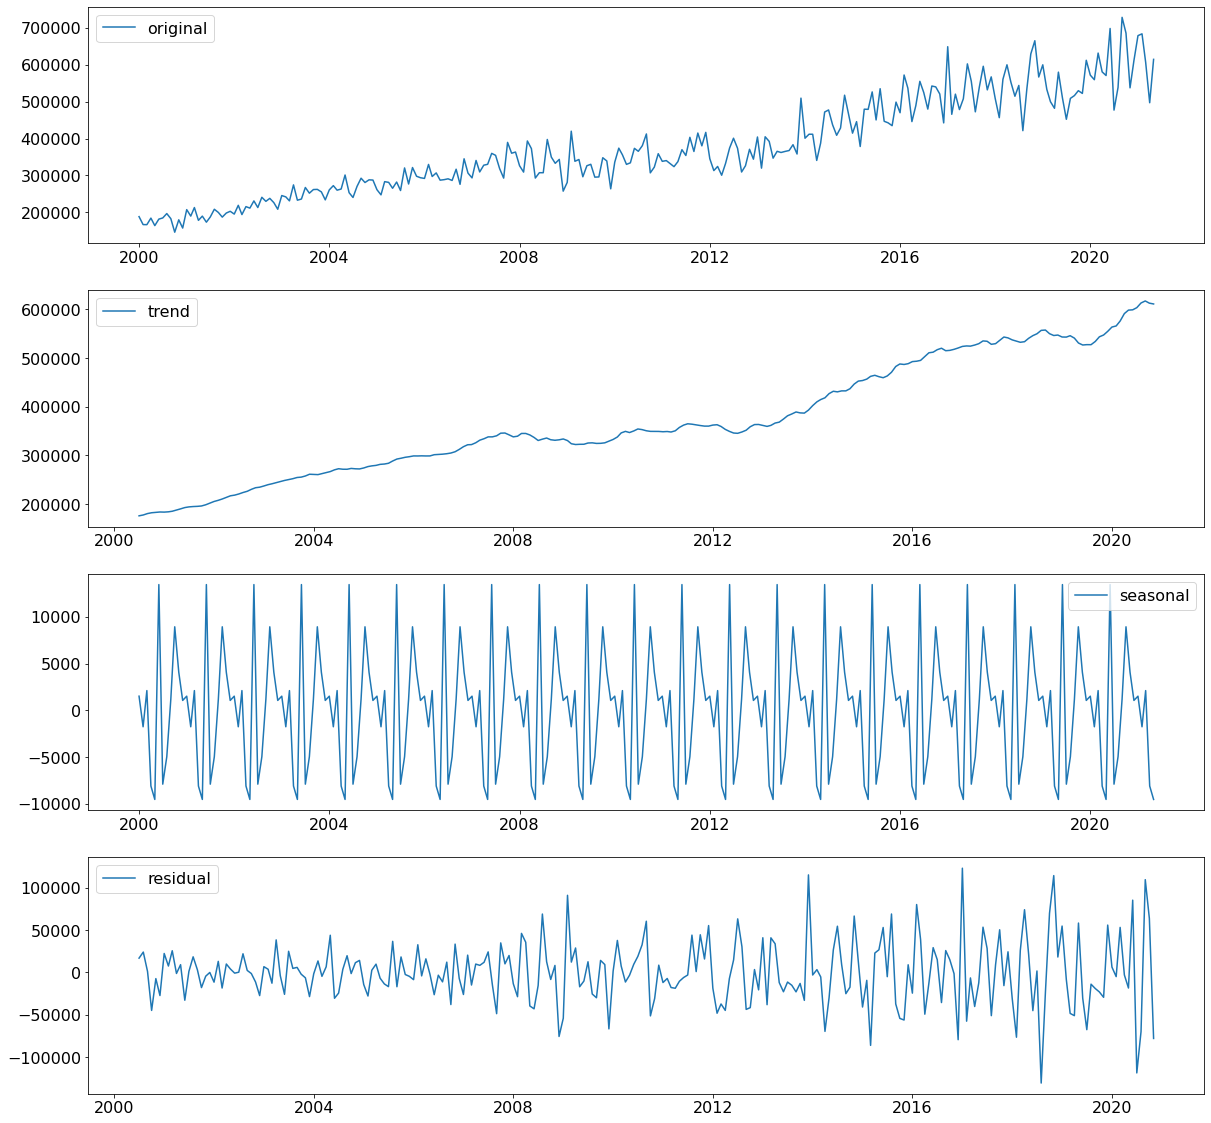

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposistion=seasonal_decompose(br1_sar,freq=12)

trend=decomposistion.trend
seasonal=decomposistion.seasonal
residual=decomposistion.resid
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(br1_sar,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residual')
plt.legend(loc='best')

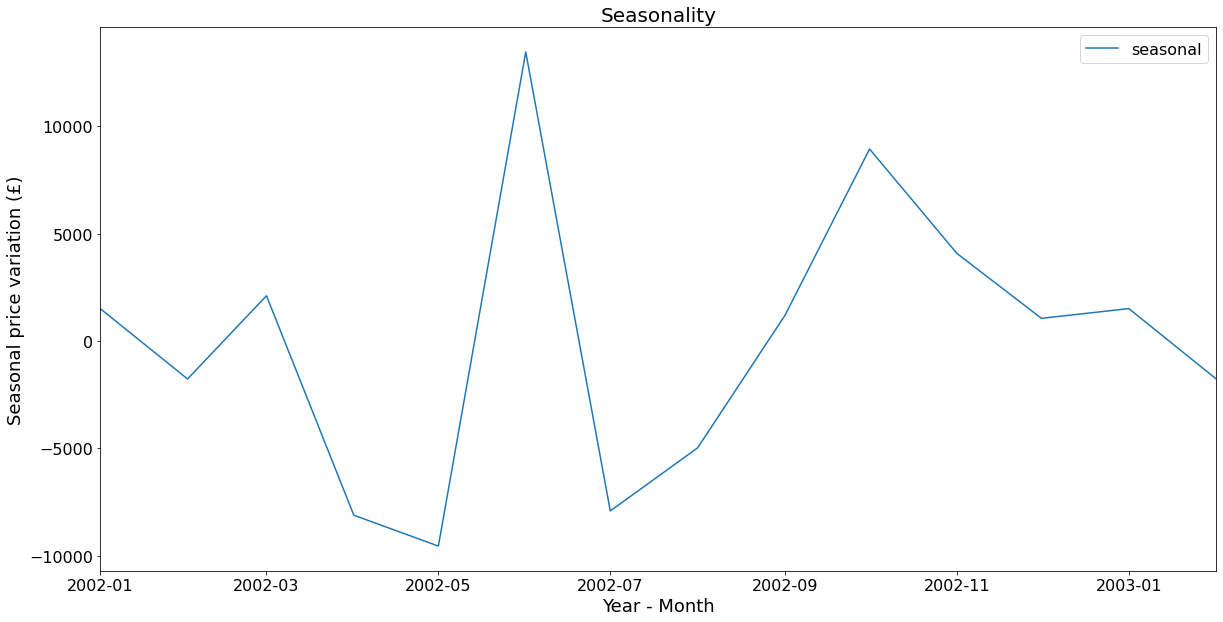

In [136]:
import datetime
import matplotlib.dates as dates
plt.figure(figsize=(20,10))
plt.plot(seasonal,label='seasonal')
plt.xlim(dates.date2num([seasonal.index[24], seasonal.index[37]]))
plt.xlabel("Year - Month", fontsize='18')
plt.ylabel("Seasonal price variation (£)", fontsize='18')
plt.title("Seasonality", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [138]:

# Using groupby to find the seasonal trend for each year
seasonal=seasonal.reset_index()
seasonal['Year']=seasonal['ds'].dt.year
seasonal_year=seasonal.groupby('Year')

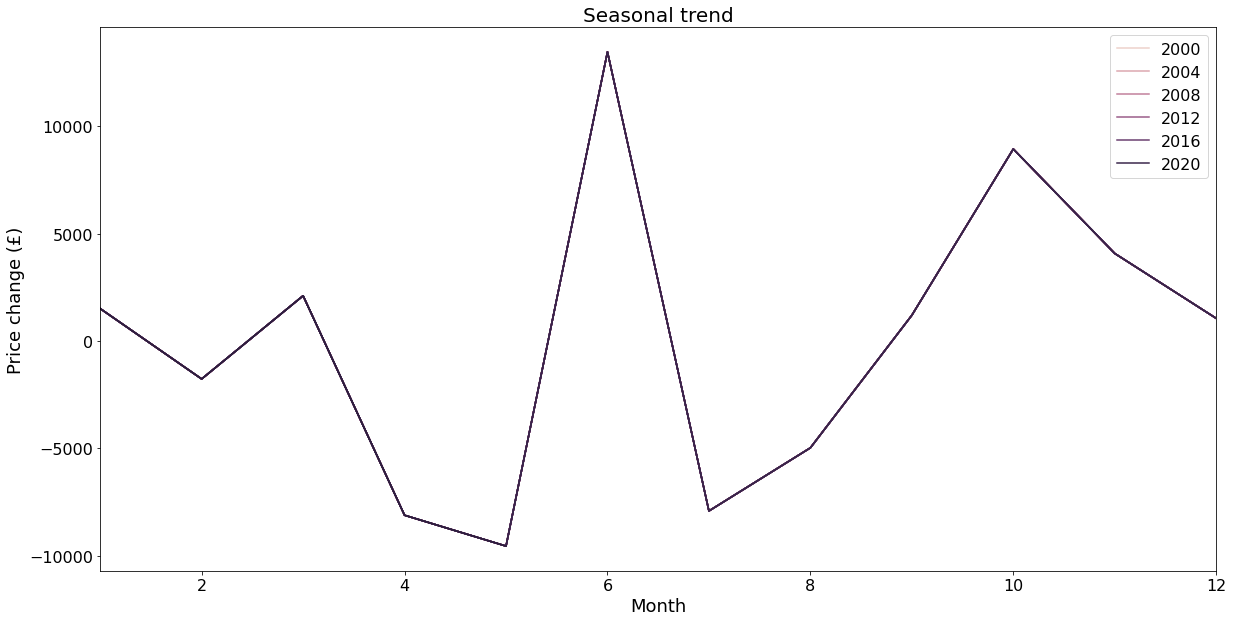

In [139]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.lineplot(x=(seasonal['ds'].dt.month),y=seasonal['seasonal'],hue='Year',data=seasonal);

plt.xlabel("Month", fontsize='18')
plt.ylabel("Price change (£)", fontsize='18')
plt.title("Seasonal trend", fontsize='20')
plt.xlim([1,12])
plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.legend(loc='best')
plt.show()


In [140]:
#Train-test split, 20 years of training data and 5 years of test data
br1_sar_train=br1_sar[br1_sar.index[0]:( br1_sar.index[br1_sar.index.get_loc('2016-01-01', method='nearest')])]
br1_sar_test=br1_sar[ br1_sar.index[br1_sar.index.get_loc('2015-7-30', method='nearest')]:br1_sar.index[-1]]

In [143]:
import statsmodels.api as sm
#Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(br1_sar_train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-pa

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5421.753308445712
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4983.38709613577
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4407.518727099683


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4116.776675631918
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4413.296127568787


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4380.455771403944
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4135.350647208033


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4111.913354056642
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5264.934362332543
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4911.093572309214

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4378.8514472105


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4079.599004134291
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4939.488485635469


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4886.582938032643
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4118.046884167634


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4071.4963269834734
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4602.715325177451


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4319.606870764719
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4464.207425737577


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4075.2173396153175
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4341.004359203211


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4320.095324236972


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4118.089889197043


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4057.4407000997476


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4501.672054921928


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4226.4387175480015


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4346.993839275476


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4002.575880192918
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4272.885145453183


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4228.135513455038
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4060.2624097094003


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3999.242131365625
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4627.9270564211365
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =4344.064162456043
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4400.520656846742

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-pa


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4088.4343542971683

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4398.0314089467465

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4344.492948364939


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4078.9323484784786


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4077.313377843725


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =4519.074154948524


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =4243.467367979107


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4365.465889938343


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4019.43930452769


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =4266.636301521162


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =4245.327680739872


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =4055.2271425711697


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =4016.269039528889
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =4567.053833676151
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =4289.819688061327


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-pa

ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4418.503439258077


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =4056.610119332575
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =4289.535119456626


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =4290.945797842622


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =4070.402409951441


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =4053.001529420724
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =4503.040679736556


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =4227.742444280957


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =4348.985490653403


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =4004.4850700506627


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =4251.272800210784


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =4229.412469063076
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =4037.949661263194


C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =4000.8337245877246


In [144]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]


pdq         (0, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3999.24
Name: 31, dtype: object

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


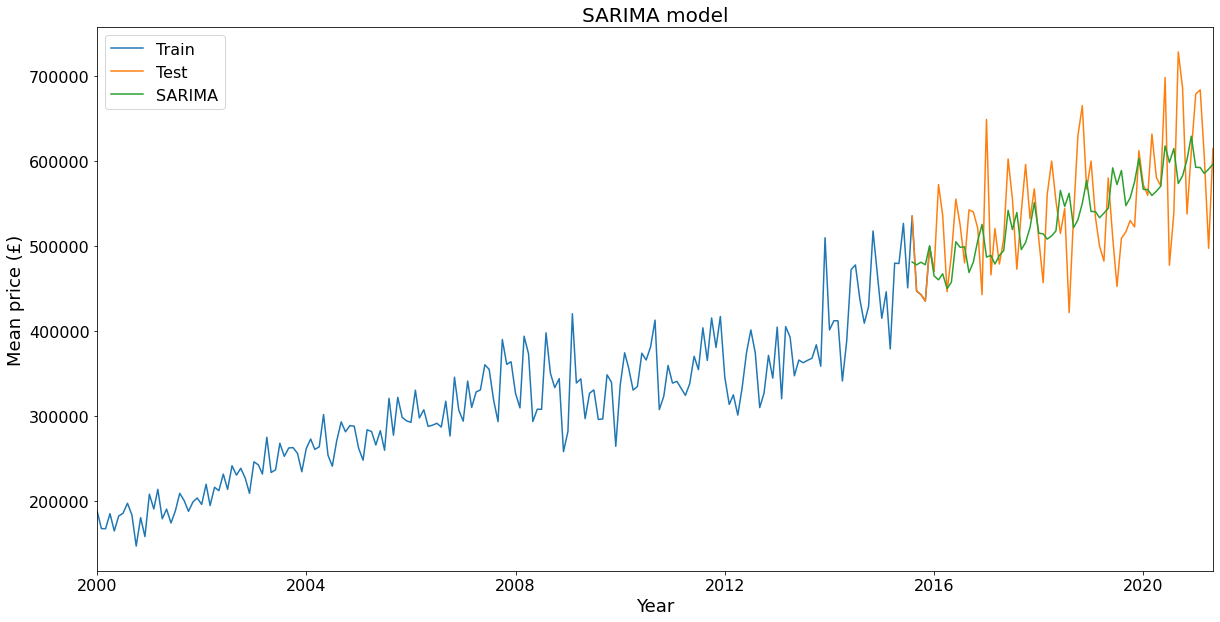

In [145]:

import statsmodels.api as sm
from datetime import datetime
#SARIMA
y_hat_avg = br1_sar_test.copy()
fit2 = sm.tsa.statespace.SARIMAX(br1_sar_train, order=(0, 1, 1),seasonal_order=(1,1,1,12)).fit()
y_hat_avg['SARIMA'] = fit2.predict(start=br1_sar_test.index[0],end=br1_sar_test.index[-1])
plt.figure(figsize=(20,10))
plt.plot( br1_sar_train, label='Train')
plt.plot(br1_sar_test, label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([br1_sar_train.index[0], br1_sar_test.index[-1]]))
plt.ylabel("Mean price (£)", fontsize='18')
plt.title("SARIMA model", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [146]:
#Creating a test date set of future dates
br1_test_future=br1_sar_test
br1_test_future.index=br1_test_future.index+pd.DateOffset(years=5)

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


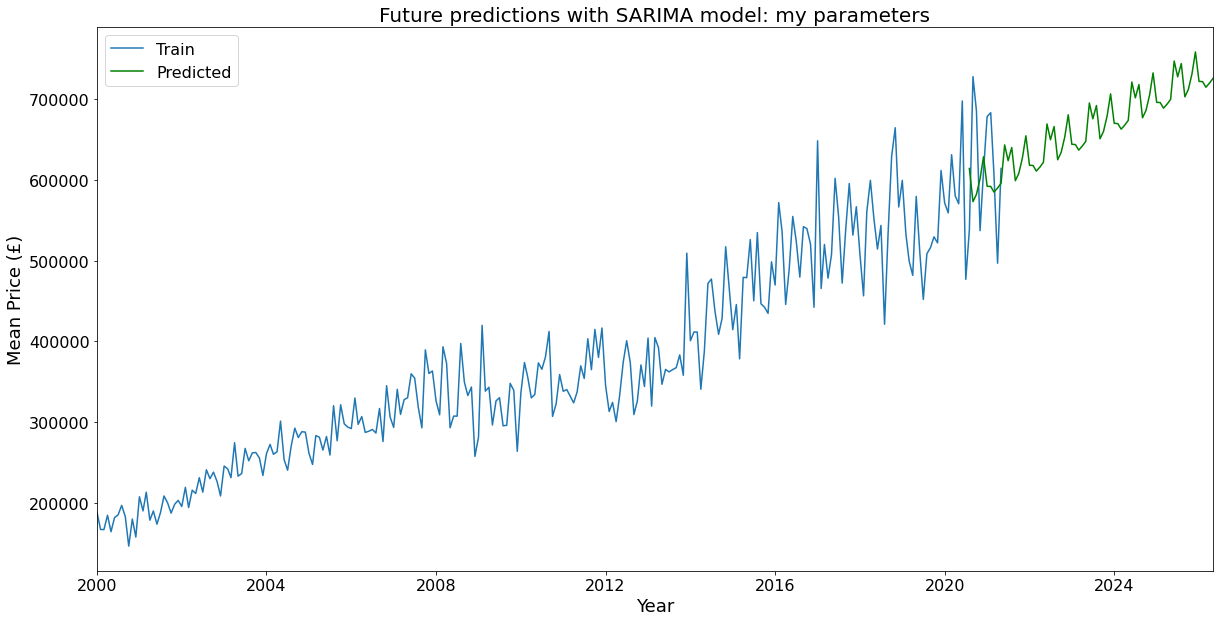

In [178]:
#Creating a test date set of future dates
br1_test_future=br1_sar_test
br1_test_future.index=br1_test_future.index+pd.DateOffset(years=5)
y_hat_avg_future = br1_test_future.copy()
fit_future = sm.tsa.statespace.SARIMAX(br1_sar, order=(0, 1, 1),seasonal_order=(1,1,1,12)).fit()
y_hat_avg_future['SARIMA'] = fit2.predict(start=br1_test_future.index[0],end=br1_test_future.index[-1])
plt.figure(figsize=(20,10))
plt.plot( br1_sar, label='Train')
plt.plot(y_hat_avg_future['SARIMA'], label='Predicted', color='g')
plt.legend(loc='best')
plt.xlabel("Year", fontsize='18')
plt.xlim(dates.date2num([br1_sar_train.index[0], br1_test_future.index[-1]]))
plt.ylabel("Mean Price (£)", fontsize='18')
plt.title("Future predictions with SARIMA model: my parameters", fontsize='20')

plt.legend(loc='best')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.show()

In [192]:
# Plug the optimal parameter values into a new SARIMAX model
model = sm.tsa.statespace.SARIMAX(diff,order=(0,1,1),seasonal_order=(1,1,1,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

# Fit the model and print results
output = model.fit()

C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [193]:
print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000    443.843     -0.002      0.998    -870.916     868.916
ar.S.L12      -0.2753      0.072     -3.850      0.000      -0.415      -0.135
ma.S.L12      -0.8422      0.063    -13.320      0.000      -0.966      -0.718
sigma2         0.0482     21.394      0.002      0.998     -41.883      41.979


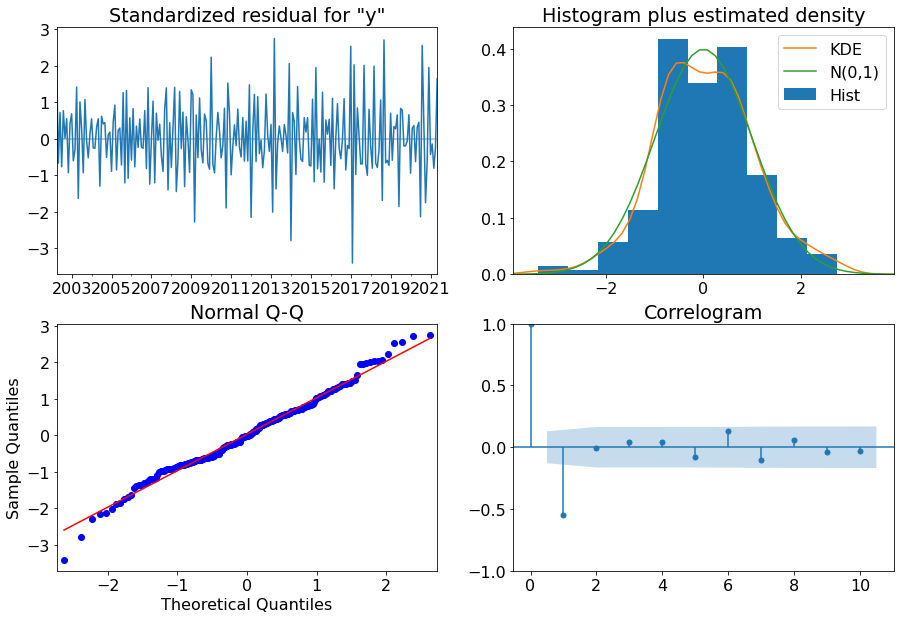

In [194]:
# Call plot_diagnostics() on the results calculated above 
fig=output.plot_diagnostics(figsize=(15,10))

# One Step Ahead

In [195]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

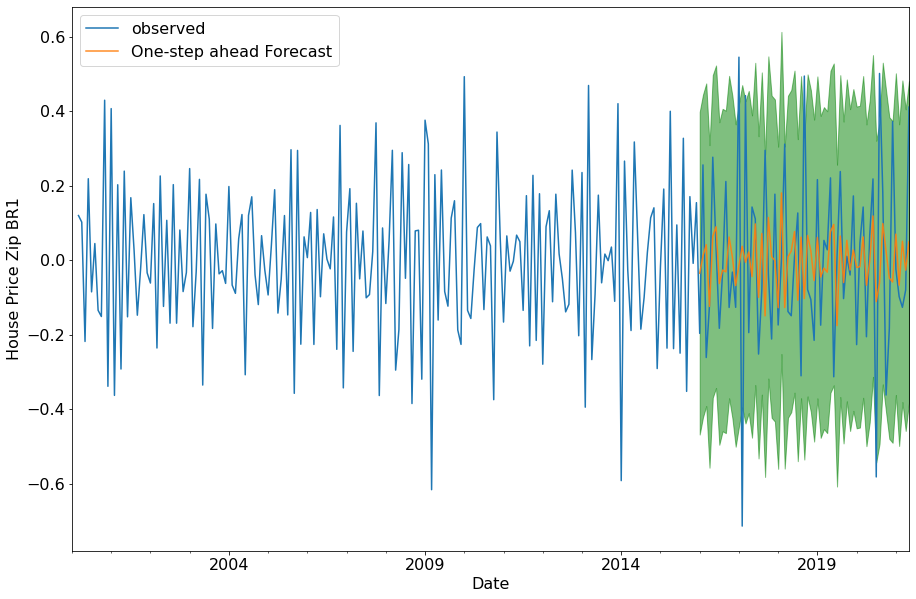

In [196]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# Plot observed values
ax = diff['2000':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('House Price Zip BR1')
plt.legend()

plt.show()

In [197]:
# Get the real and predicted values
br1_forecasted = pred.predicted_mean
br1_truth = diff['2000-01-01':]

# Compute the mean square error
mse = ((br1_forecasted - br1_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [199]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_history=True)
pred_dynamic_conf = pred_dynamic.conf_int()

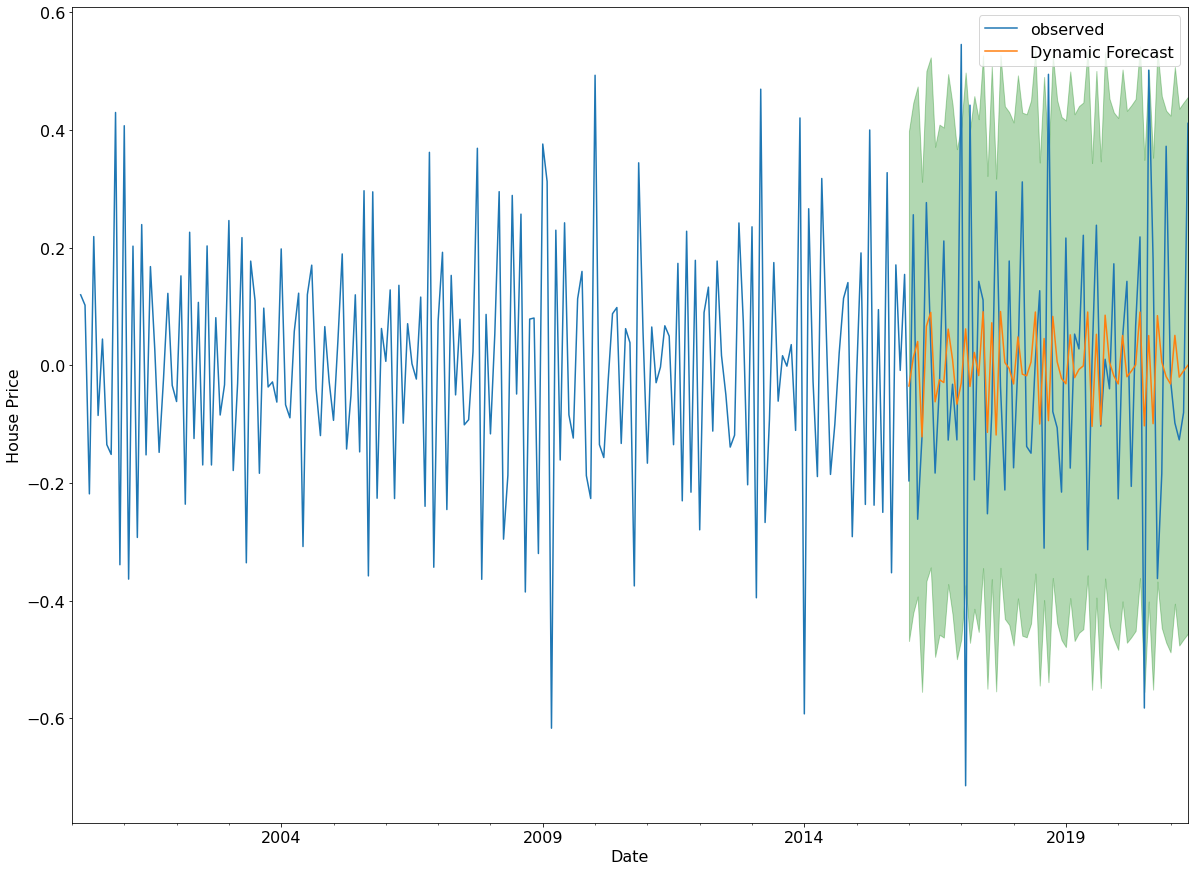

In [202]:
# Plot the dynamic forecast with confidence intervals as above
ax = diff['2000':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

#ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2000-01-01'), br1_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()

In [360]:
list_of_zips = list(df1['zip'].unique())
list_of_zips.remove('CM14')
list_of_zips.remove('EC2N')

In [316]:
# Define table as a dataframe with specific columns. Each column's values will be a list that we will add to.
list_of_zips = list(df1['zip'].unique())
summary = pd.DataFrame({'Zip': [], 'Test MPE':[]})


summary

Empty DataFrame
Columns: [Zip, Test MPE]
Index: []

In [ ]:
for x,i in enumerate(list_of_zips):
    df = df1[df1['zip']==i].copy()
    if len(df) < 257:
        continue
    #print(df.head())
    df.drop('zip', axis=1, inplace=True)
    #print(df.head())
    df.columns = ['ds', 'y']
    df.set_index('ds', inplace=True)
    df = df['y']
    df = df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
    print(i)
    print(df.head())
    train_df = df[df.index < '2017-12-01']
    test_df = df[(df.index >= '2017-12-01') & (df.index < '2019-01-01')]
    val_df = df[(df.index >= '2019-01-01') & (df.index < '2021-05-01')]
    cbrt_train = np.cbrt(train_df)
    arimamodel = SARIMAX(cbrt_train, order = (4,1,2), seasonal_order = (1,1,0,12), freq='MS')
    fit_model = arimamodel.fit()
    yhat = fit_model.forecast(len(test_df))
    # undo the cube root in order to compare to the test data
    yhat = yhat**3
    mpe = mean_percent_error(test_df,yhat)
    summary.loc[x] = [i, mpe]
    print('simple arima mean percent error: ', mpe)
    plt.figure(figsize=(20,10))
    plt.plot(yhat, label = 'Prediction')
    plt.plot(df[df.index < '2019-01-01'], label = 'True')
    plt.legend()
    plt.savefig('{}.png'.format(i), bbox_inches = 'tight')
    

In [353]:
summary.head(50)

zip         mpe
0    BR1    0.123844
1    BR2    0.102355
2    BR3    0.123614
3    BR4    0.228745
4    BR5   0.0753263
5    BR6    0.084625
6    BR7    0.173382
7    BR8   0.0697984
8   CM13  0.00688681
9    CR0   0.0825456
10   CR2   0.0822733
11   CR3    0.140802
12   CR4    0.210425
13   CR5    0.088726
14   CR6     1.85148
15   CR7    0.119449
16   CR8    0.128391
17   CR9    0.433702
18   DA1    0.106614
19  DA14    0.137418
20  DA15    0.105941
21  DA16    0.128787
22  DA17    0.215285
23  DA18     0.29774
24   DA5    0.165872
25   DA6    0.139088
26   DA7   0.0315665
27   DA8    0.163983
28    E1    0.223413
29   E10    0.353068
30   E11   0.0926724
31   E12    0.271582
32   E13    0.142578
33   E14   0.0777738
34   E15    0.152226
35   E16   0.0893903
36   E17    0.189069
37   E18    0.189257
38   E1W    0.239739
39    E2    0.179227
40   E20      0.5537
41    E3    0.113225
42    E4   0.0606925
43    E5   0.0881656
44    E6     0.17947
45    E7     0.11348
46    E8    0.160563
47    E9    0.134094
48  EC1A    0.397042
49  EC1M     1.10617

In [359]:
pd.set_option('display.max_rows', None)
print(summary)

      zip                                                mpe
0     BR1                                           0.123844
1     BR2                                           0.102355
2     BR3                                           0.123614
3     BR4                                           0.228745
4     BR5                                          0.0753263
5     BR6                                           0.084625
6     BR7                                           0.173382
7     BR8                                          0.0697984
8    CM13                                         0.00688681
9     CR0                                          0.0825456
10    CR2                                          0.0822733
11    CR3                                           0.140802
12    CR4                                           0.210425
13    CR5                                           0.088726
14    CR6                                            1.85148
15    CR7               